<h1>Credit Card Default</h1>
<h2>Data Exploration and Cleaning</h2>

<p>Our client is a credit card company. They have brought us a dataset that includes demographics and recent financial data over the past six months for a sample of 30,000 account holders. This data is at the credit account level; in other words, there is one row for each account. Rows are labelled by whether, in the next month after the 6-month historical data period, an account owner has defaulted, or in other words, failed to make the minimum payment.</p>
<p>Our goal is to develop a predictive model for whether an account will default next month, given demographics and historical data.</p>

In [1]:
import numpy as np # Numerical computation library
import pandas as pd # Data manipulation and analysis library
import matplotlib.pyplot as plt # Plotting library for creating static, animated, and interactive visualizations

# Render plots inline within Jupyter notebooks
%matplotlib inline

import matplotlib as mpl # Additional functionality for Matplotlib
import seaborn as sns

# Set the resolution for figures to 400 DPI (dots per inch) for high-quality plots
mpl.rcParams['figure.dpi'] = 400

# Set the default font size for plots to 5 for better readability
mpl.rcParams['font.size'] = 5

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df_raw = pd.read_excel('raw-data-credit-card-default.xls') # to load the Excel file into a DataFrame

In [3]:
df_raw.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  int64 
 2   SEX                         30000 non-null  int64 
 3   EDUCATION                   30000 non-null  int64 
 4   MARRIAGE                    30000 non-null  int64 
 5   AGE                         30000 non-null  int64 
 6   PAY_1                       30000 non-null  object
 7   PAY_2                       30000 non-null  int64 
 8   PAY_3                       30000 non-null  int64 
 9   PAY_4                       30000 non-null  int64 
 10  PAY_5                       30000 non-null  int64 
 11  PAY_6                       30000 non-null  int64 
 12  BILL_AMT1                   30000 non-null  int64 
 13  BILL_AMT2                   30000 non-null  in

In [5]:
df_raw.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


<p>The account ID column is referenced as <code>ID</code>. The remaining columns are our features, with the last column being the response variable.</p>
<p><code>LIMIT_BAL</code>: Amount of credit provided (in New Taiwanese (NT) dollars), including individual consumer credit and family (supplementary) credit.</p>
<p><code>SEX</code>: Gender (1 = male; 2 = female). Due to ethical considerations, we will not utilize gender information to determine creditworthiness.</p>
<p><code>EDUCATION</code>: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).</p>
<p><code>MARRIAGE</code>: Marital status (1 = married; 2 = single; 3 = others).</p>
<p><code>AGE</code>: Age (in years).</p>
<p><code>PAY_1</code>-<code>PAY_6</code>: A record of past payments. Past monthly payments, recorded from April to September, are stored in these columns. <code>PAY_1</code> represents the repayment status in September; <code>PAY_2</code> is the repayment status in August; and so on, up to <code>PAY_6</code>, which represents the repayment status in April.</p>
<p>The repayment status measurement scale is as follows: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; and so on up to 8 = payment delay for eight months; 9 = payment delay for nine months and above.</p>
<p><code>BILL_AMT1</code>-<code>BILL_AMT6</code>: Bill statement amount (in NT dollars). <code>BILL_AMT1</code> represents the bill statement amount in September; <code>BILL_AMT2</code> represents the bill statement amount in August; and so on, up to <code>BILL_AMT6</code>, which represents the bill statement amount in April.</p>
<p><code>PAY_AMT1</code>-<code>PAY_AMT6</code>: Amount of previous payment (in NT dollars). <code>PAY_AMT1</code> represents the amount paid in September; <code>PAY_AMT2</code> represents the amount paid in August; and so on, up to <code>PAY_AMT6</code>, which represents the amount paid in April.</p>

In [6]:
df_raw['ID'].nunique()

29687

<p>The preceding output shows 29,687 unique entries, while the dataset contains 30,000 total rows, as seen in the following output.</p>

In [7]:
df_raw.shape

(30000, 25)

<p>The number of unique IDs is lower than the total number of rows in the data, suggesting that the ID is not a unique identifier for each row. This indicates that there are some duplicate IDs within the data. However, we need to determine the extent of these duplications. Are there many instances of a single ID being duplicated, or are there multiple IDs that have been duplicated?</p>

In [8]:
id_counts = df_raw['ID'].value_counts() # .value_counts(): This is similar to a group by/count procedure in SQL.
id_counts.head()

ID
ad23fe5c-7b09    2
1fb3e3e6-a68d    2
89f8f447-fca8    2
7c9b7473-cc2f    2
90330d02-82d9    2
Name: count, dtype: int64

In [9]:
id_counts.value_counts() # to display the number of duplicated entries

count
1    29374
2      313
Name: count, dtype: int64

<p>313 IDs occur twice; no ID occurs more than twice.</p>

In [10]:
dupe_mask = id_counts == 2 # to create a Boolean mask that locates the duplicate IDs
dupe_mask[0:5]

ID
ad23fe5c-7b09    True
1fb3e3e6-a68d    True
89f8f447-fca8    True
7c9b7473-cc2f    True
90330d02-82d9    True
Name: count, dtype: bool

In [11]:
dupe_ids = id_counts.index[dupe_mask] # to select and store the duplicated IDs
dupe_ids = list(dupe_ids)
len(dupe_ids)

313

In [12]:
dupe_ids[0:5]

['ad23fe5c-7b09',
 '1fb3e3e6-a68d',
 '89f8f447-fca8',
 '7c9b7473-cc2f',
 '90330d02-82d9']

<p>From the preceding output, we can observe that the list contains the required entries of duplicate IDs. We're now in a position to examine the data for the IDs in our list of duplicates. In particular, we'd like to look at the features' values to see what, if anything, might be different between these duplicate entries.</p>

In [13]:
# Using the first three IDs on our list of dupes, dupe_ids[0:3], we will plan first to find the rows containing these IDs.
# If we pass this list of IDs to the .isin method of the ID Series, this will create another logical mask we can use on
# the larger DataFrame to display the rows with these IDs. The .isin method is nested in a .loc statement
# indexing the DataFrame to select the location of all rows containing True in the Boolean mask.
# The second argument of the .loc indexing statement is :, which implies that all columns will be selected.
# By performing the following steps, we filter the DataFrame to view all the columns for the first three duplicate IDs.

df_raw.loc[df_raw['ID'].isin(dupe_ids[0:3]), :]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
5033,89f8f447-fca8,320000,2,2,1,32,0,0,0,0,...,169371,172868,150827,8000,8000,5500,6100,6000,5000,0
5133,89f8f447-fca8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16727,1fb3e3e6-a68d,80000,1,2,2,33,2,2,0,0,...,27394,29922,31879,0,2000,2000,3000,2600,0,1
16827,1fb3e3e6-a68d,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29685,ad23fe5c-7b09,50000,1,3,1,32,0,0,0,0,...,12882,8131,3983,3000,2871,1000,163,3983,3771,1
29785,ad23fe5c-7b09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<p>Each duplicate ID appears to have one row with valid data and one entirely zeros.</p>
<p>A row of all zeros is invalid data because it does not make sense for someone to have an age, credit limit, etc. of 0.</p>
<p>One approach to dealing with this issue would be finding rows with all zeros except for the first column, which has the IDs. These would be invalid data in any case, and it may be that if we get rid of all of them, we would also solve our problem of duplicate IDs.</p>

In [14]:
df_zero_mask = df_raw == 0 # to create a Boolean matrix of the same size as the entire DataFrame
df_zero_mask.head() # df_zero_mask: DataFrame containing Boolean values

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,False,True,True,True,True,False
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,True,False,False,False,True,False,False
2,False,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True


In [15]:
# to create a Boolean Series that identifies every row where all the elements starting from the second column
# (the features and response, but not the IDs) are 0

# we first need to index df_zero_mask using the integer indexing (.iloc) method
# we pass (:) to examine all rows and (1:) to examine all columns starting with the second one (index 1)
# we will apply the all() method along the column axis (axis=1), which will return True if and only if every column in that row is True

feature_zero_mask = df_zero_mask.iloc[:, 1:].all(axis=1)
sum(feature_zero_mask) # to calculate the sum of the Boolean Series

315

<p>The previous output shows 315 rows with zeros for every column except the first one. This exceeds the number of duplicate IDs (313), so deleting all the "zero rows" may resolve the duplicate ID issue.</p>

In [16]:
df_clean_v1 = df_raw.loc[~feature_zero_mask, :].copy()

# While performing the cleaning operation in the preceding step, we return a new DataFrame called df_clean_1.
# We've used the .copy() method after the .loc indexing operation to create a copy of this output,
# as opposed to a view on the original DataFrame.
# Within the .loc method, we used the logical not operator, ~,
# to select all the rows that don't have zeros for all the features and the response variable, and : to select all columns.

df_clean_v1.shape

(29685, 25)

<p>This is the valid data we want to retain. After this, we need to verify if the remaining row count matches the number of unique IDs.</p>

In [17]:
df_clean_v1['ID'].nunique()

29685

<p>Duplicates have been successfully eliminated, as the number of unique IDs matches the number of rows in the output.</p>
<p>We have identified a data quality issue with the metadata. Initially, we were informed that each sample in our dataset corresponded to a unique account ID, but we discovered this was inaccurate. After addressing this problem, we will not pay attention to the metadata column of account IDs in the upcoming steps, as it will not help us develop a predictive model for credit default.</p>

In [18]:
df_clean_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29685 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          29685 non-null  object
 1   LIMIT_BAL                   29685 non-null  int64 
 2   SEX                         29685 non-null  int64 
 3   EDUCATION                   29685 non-null  int64 
 4   MARRIAGE                    29685 non-null  int64 
 5   AGE                         29685 non-null  int64 
 6   PAY_1                       29685 non-null  object
 7   PAY_2                       29685 non-null  int64 
 8   PAY_3                       29685 non-null  int64 
 9   PAY_4                       29685 non-null  int64 
 10  PAY_5                       29685 non-null  int64 
 11  PAY_6                       29685 non-null  int64 
 12  BILL_AMT1                   29685 non-null  int64 
 13  BILL_AMT2                   29685 non-null  int64 


<p>Each row in the DataFrame contains 29,685 non-null values, indicating that no data is missing. However, if a fill value represents missing data, it may not be immediately apparent in the current view.</p>
<p>Most columns have <code>int64</code> next to them, indicating they are of integer data type. The exceptions are <code>ID</code> and <code>PAY_1</code>. We are already familiar with <code>ID</code>; it contains strings, which are account IDs. What about <code>PAY_1</code>? According to the data dictionary, this should include integers, like all the other features. Let's take a closer look at this column.</p>

In [19]:
df_clean_v1['PAY_1'].head()

# The integers on the left of the output represent the DataFrame index, which consists of consecutive integers starting with 0.
# The data from the PAY_1 column is displayed on the right.

0     2
1    -1
2     0
3     0
4    -1
Name: PAY_1, dtype: object

In [20]:
df_clean_v1['PAY_1'].value_counts()

PAY_1
0                13087
-1                5047
1                 3261
Not available     3021
-2                2476
2                 2378
3                  292
4                   63
5                   23
8                   17
6                   11
7                    9
Name: count, dtype: int64

<p>The preceding output reveals the presence of two undocumented values, 0 and –2, as well as the reason this column was imported by pandas as an <code>object</code> data type instead of <code>int64</code> as we would expect for integer data: there is a <code>Not available</code> string present in this column, symbolizing missing data.</p>

In [21]:
valid_pay_1_mask = df_clean_v1['PAY_1'] != 'Not available'
valid_pay_1_mask[0:5]

0    True
1    True
2    True
3    True
4    True
Name: PAY_1, dtype: bool

In [22]:
sum(valid_pay_1_mask) # 29,685 - 3,021 = 26,664

26664

In [23]:
df_clean_v2 = df_clean_v1.loc[valid_pay_1_mask, :].copy()
df_clean_v2.shape

(26664, 25)

In [24]:
df_clean_v2['PAY_1'].value_counts()

PAY_1
0     13087
-1     5047
1      3261
-2     2476
2      2378
3       292
4        63
5        23
8        17
6        11
7         9
Name: count, dtype: int64

<p>To make this column's data type consistent with the others, we will cast it from the generic <code>object</code> type to <code>int64</code> like all the other features, using the <code>.astype</code> method.</p>

In [25]:
df_clean_v2['PAY_1'] = df_clean_v2['PAY_1'].astype('int64')
df_clean_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26664 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          26664 non-null  object
 1   LIMIT_BAL                   26664 non-null  int64 
 2   SEX                         26664 non-null  int64 
 3   EDUCATION                   26664 non-null  int64 
 4   MARRIAGE                    26664 non-null  int64 
 5   AGE                         26664 non-null  int64 
 6   PAY_1                       26664 non-null  int64 
 7   PAY_2                       26664 non-null  int64 
 8   PAY_3                       26664 non-null  int64 
 9   PAY_4                       26664 non-null  int64 
 10  PAY_5                       26664 non-null  int64 
 11  PAY_6                       26664 non-null  int64 
 12  BILL_AMT1                   26664 non-null  int64 
 13  BILL_AMT2                   26664 non-null  int64 


<p>We also noticed the undocumented values of –2 and 0 in <code>PAY_1</code>. We got back in touch with our business partner and learned the following information:</p>
<ul>
    <li>-2 means the account started that month with a zero balance and never used any credit.</li>
    <li>0 means that at least the minimum payment was made, but the entire balance wasn't paid (a positive balance was carried to the next month).</li>
</ul>
<p><code>LIMIT_BAL</code> and <code>AGE</code> are numerical features, meaning they are measured on a continuous scale. Consequently, we'll use histograms to visualize them.</p>

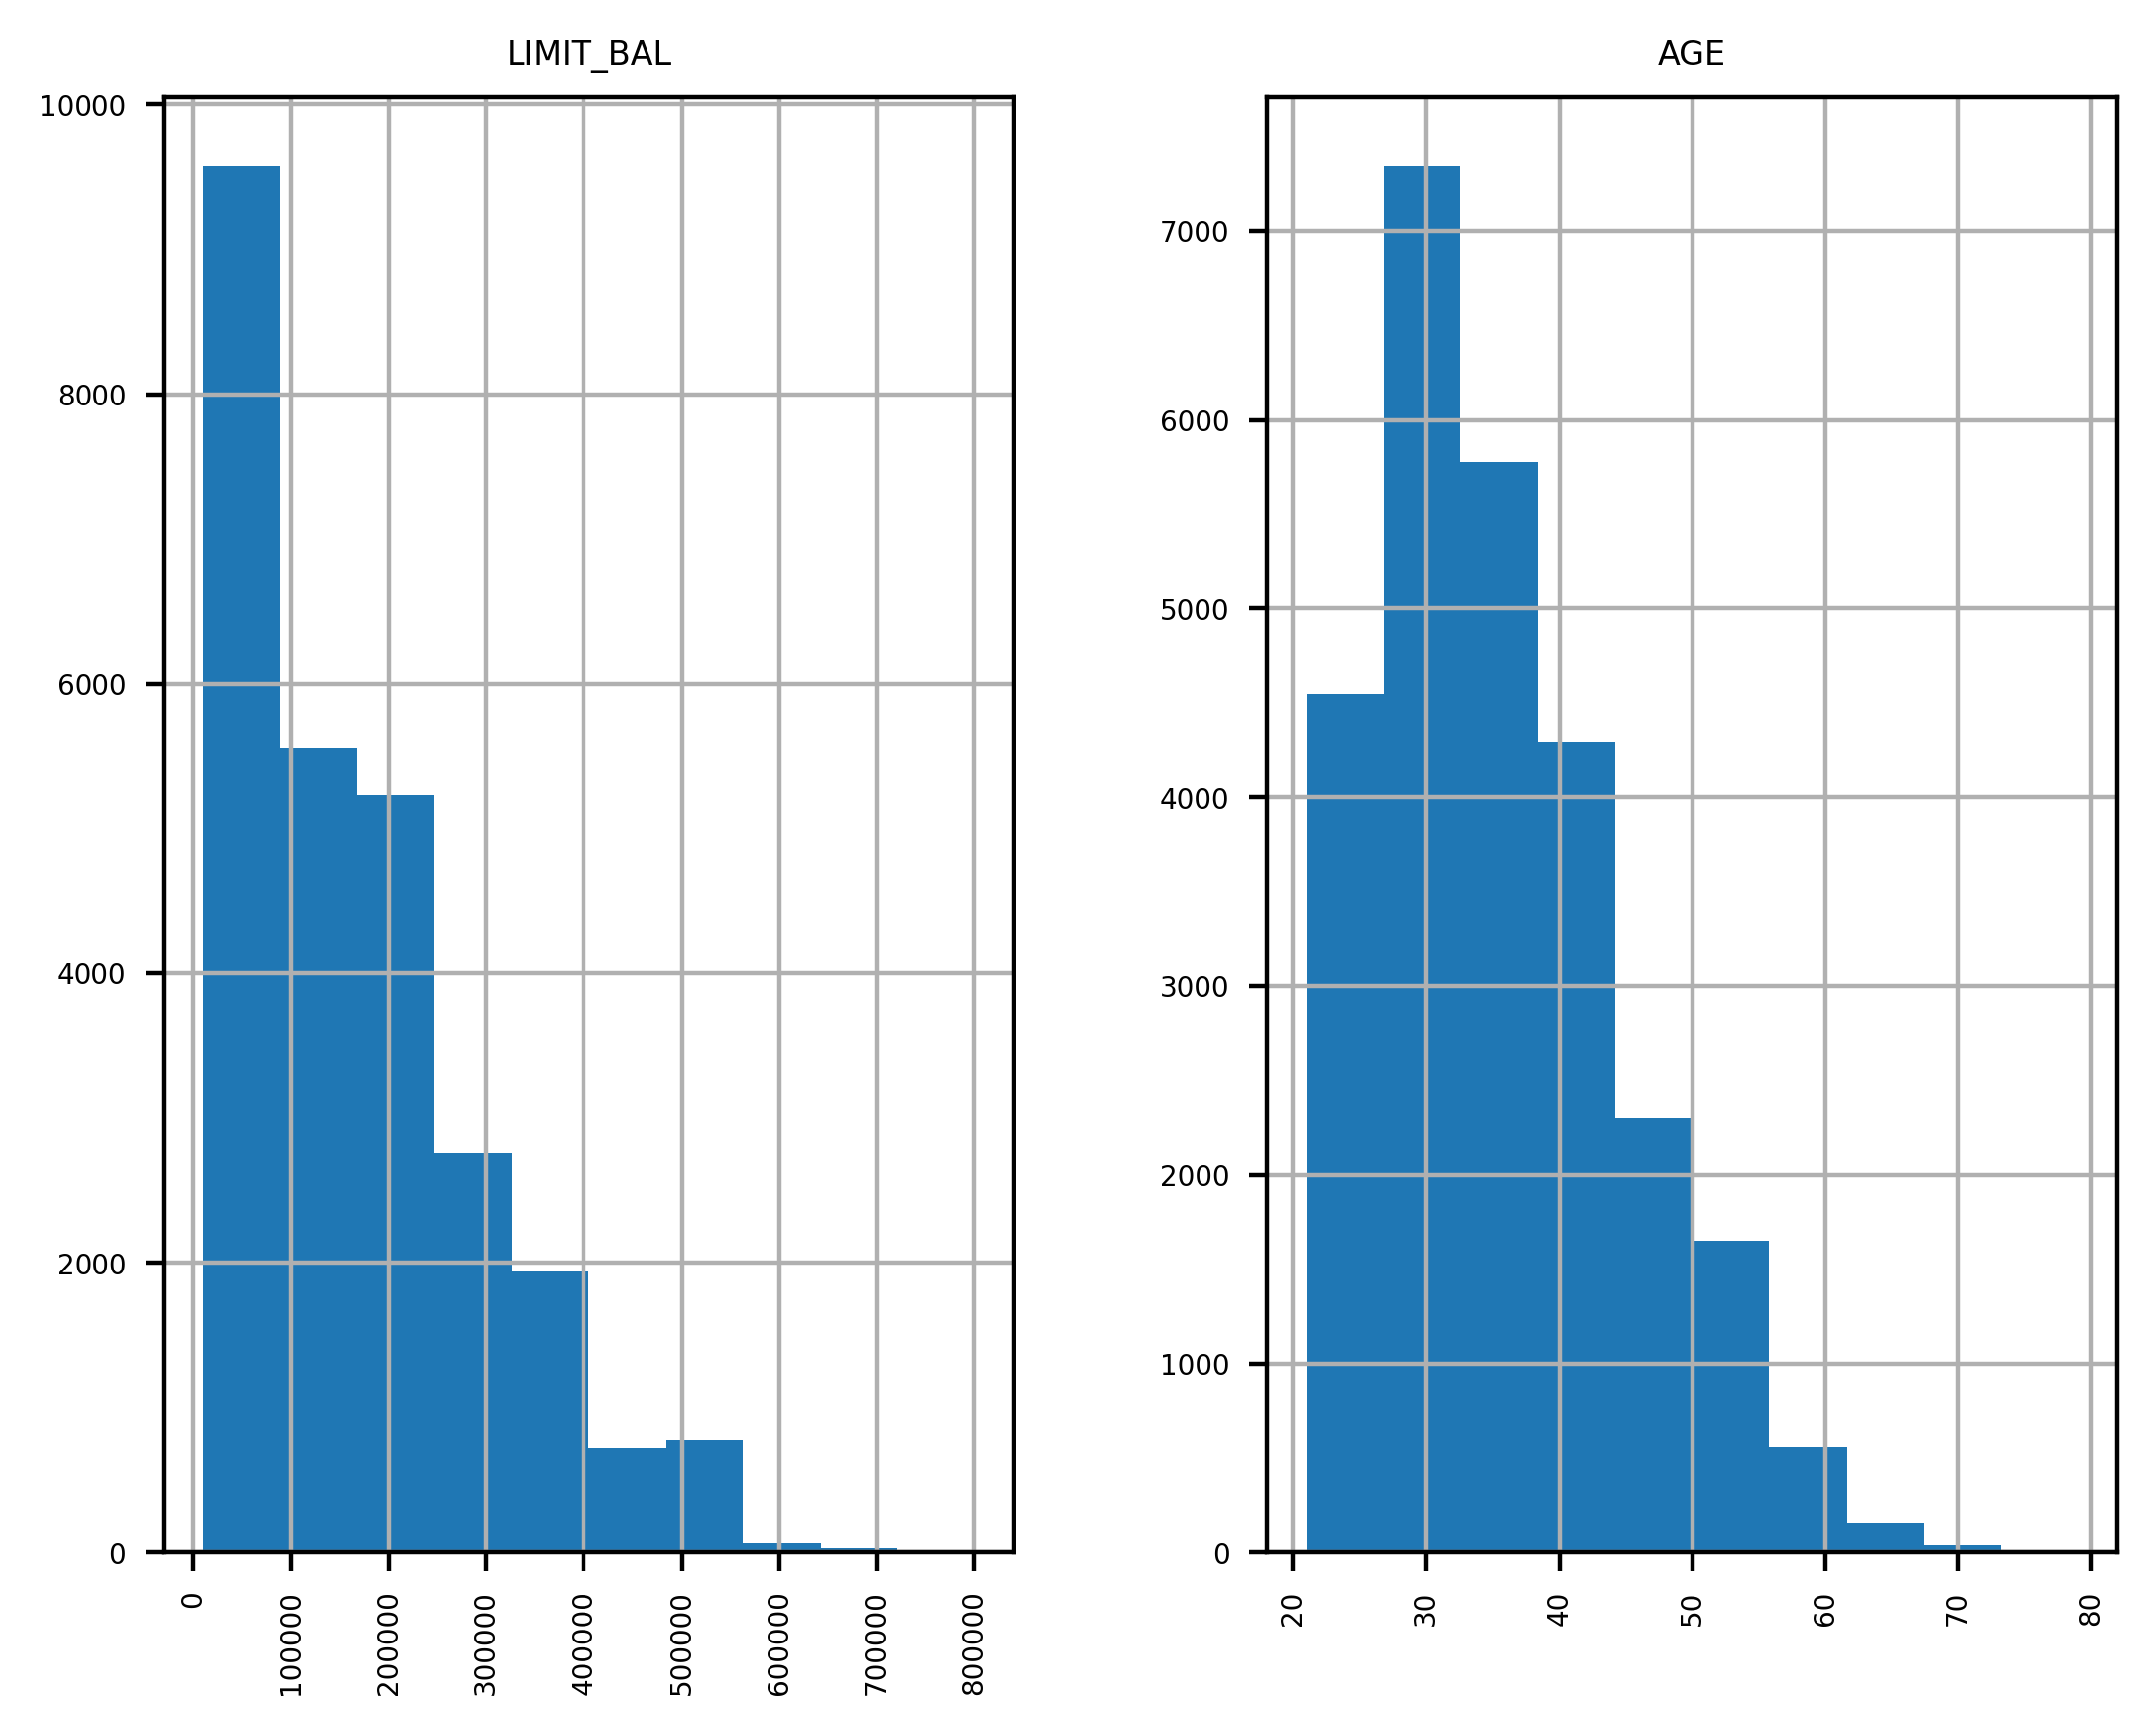

In [26]:
df_clean_v2[['LIMIT_BAL', 'AGE']].hist(xrot=90);

In [27]:
df_clean_v2[['LIMIT_BAL', 'AGE']].describe()

,LIMIT_BAL,AGE
count,26664.000000,26664.000000
mean,167919.054905,35.505213
std,129839.453081,9.227442
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,800000.000000,79.000000


<p><code>LIMIT_BAL</code>, the credit limit, is reasonable. Credit limits start at a minimum of NTD 10,000 (CAD 423.32).</p>
<p>The <code>AGE</code> feature is reasonably distributed, with no individuals under the age of 21 having a credit account.</p>
<p>Examining the value counts is helpful for categorical features because there are relatively few unique values.</p>

In [28]:
df_clean_v2['EDUCATION'].value_counts()

EDUCATION
2    12458
1     9412
3     4380
5      245
4      115
6       43
0       11
Name: count, dtype: int64

<p>Here, we see undocumented education levels 0, 5, and 6, as the data dictionary describes only <code>EDUCATION</code> (1 = graduate school; 2 = university; 3 = high school; 4 = others). Our business partner tells us they don't know about the others. Since they are not very prevalent, we will lump them in with the others category, which seems appropriate.</p>

In [29]:
df_clean_v2['EDUCATION'].replace(to_replace=[0, 5, 6], value=4, inplace=True) # inplace=True: instead of returning a new DataFrame, this operation will make the change on the existing DataFrame
df_clean_v2['EDUCATION'].value_counts()

EDUCATION
2    12458
1     9412
3     4380
4      414
Name: count, dtype: int64

In [30]:
df_clean_v2['MARRIAGE'].value_counts()

MARRIAGE
2    14158
1    12172
3      286
0       48
Name: count, dtype: int64

<p>The issue here is similar to that encountered for the <code>EDUCATION</code> feature; there is a value, 0, which is not documented in the data dictionary: 1 = married; 2 = single; 3 = others. So we'll lump it in with others.</p>

In [31]:
df_clean_v2['MARRIAGE'].replace(to_replace=0, value=3, inplace=True)
df_clean_v2['MARRIAGE'].value_counts()

MARRIAGE
2    14158
1    12172
3      334
Name: count, dtype: int64

<p>Let's consider our <code>EDUCATION</code> feature before it was encoded as an ordinal. From the data dictionary, we know that 1 = graduate school, 2 = university, 3 = high school, and 4 = others. We would like to recreate a column with these strings instead of numbers.</p>

In [32]:
df_clean_v2['EDUCATION_CAT'] = 'none'
df_clean_v2[['EDUCATION', 'EDUCATION_CAT']].head(10)

,EDUCATION,EDUCATION_CAT
0,2,none
1,2,none
2,2,none
3,2,none
4,2,none
5,1,none
6,1,none
7,2,none
8,3,none
9,3,none


In [33]:
cat_mapping = {1: 'graduate school',
               2: 'university',
               3: 'high school',
               4: 'others'}
df_clean_v2['EDUCATION_CAT'] = df_clean_v2['EDUCATION'].map(cat_mapping)
df_clean_v2[['EDUCATION', 'EDUCATION_CAT']].head(10)

,EDUCATION,EDUCATION_CAT
0,2,university
1,2,university
2,2,university
3,2,university
4,2,university
5,1,graduate school
6,1,graduate school
7,2,university
8,3,high school
9,3,high school


In [34]:
edu_ohe = pd.get_dummies(df_clean_v2['EDUCATION_CAT']) # to create a one-hot encoded DataFrame of the EDUCATION_CAT column
edu_ohe.head(10)

,graduate school,high school,others,university
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
3,False,False,False,True
4,False,False,False,True
5,True,False,False,False
6,True,False,False,False
7,False,False,False,True
8,False,True,False,False
9,False,True,False,False


In [35]:
df_clean_v3 = pd.concat([df_clean_v2, edu_ohe], axis=1)
df_clean_v3[['EDUCATION_CAT', 'graduate school', 'high school', 'university', 'others']].head(10)

,EDUCATION_CAT,graduate school,high school,university,others
0,university,False,False,True,False
1,university,False,False,True,False
2,university,False,False,True,False
3,university,False,False,True,False
4,university,False,False,True,False
5,graduate school,True,False,False,False
6,graduate school,True,False,False,False
7,university,False,False,True,False
8,high school,False,True,False,False
9,high school,False,True,False,False


<p>We have taken a single column, <code>EDUCATION</code>, and expanded it into multiple columns based on the levels in the feature. Since there are only four levels, this is a minor issue. However, if your categorical variable has numerous levels, consider using a different approach, such as grouping some levels into single categories.</p>

In [36]:
# We avoid including the index of the DataFrame when saving to prevent the creation of extra columns when loading it later.

df_clean_v3.to_csv('clean-data-credit-card-default.csv', index=False)
df = pd.read_csv('clean-data-credit-card-default.csv')

<p>The remaining features to be examined are the financial history features. They fall naturally into three groups: the status of the monthly payments for the last six months and the billed and paid amounts for the same period. First, let's look at the payment statuses. It is convenient to break these out as a list so we can study them together.</p>

In [37]:
pay_feats = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df[pay_feats].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,-0.017777,-0.133363,-0.167679,-0.225023,-0.269764,-0.293579
std,1.126769,1.198640,1.199165,1.167897,1.131735,1.150229
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


<p>Here, we observe that the range of values is the same for all of these features: -2, -1, 0, ... 8. It appears that the value of 9, described in the data dictionary as payment delay for nine months and above, is never observed.</p>

In [38]:
df[pay_feats[0]].value_counts().sort_index()

PAY_1
-2     2476
-1     5047
 0    13087
 1     3261
 2     2378
 3      292
 4       63
 5       23
 6       11
 7        9
 8       17
Name: count, dtype: int64

<p>Most values are either -2, -1, or 0, corresponding to an account in good standing last month: not used, paid in full, or made at least the minimum payment.</p>
<p>This dataset is small enough, with 18 financial features and a few others, to examine each feature individually. If the dataset had thousands of features, we would likely skip this and explore dimensionality reduction techniques instead. These techniques condense the information in a large number of features down to a smaller number of derived features or use feature selection methods to isolate the important features from many candidates.</p>

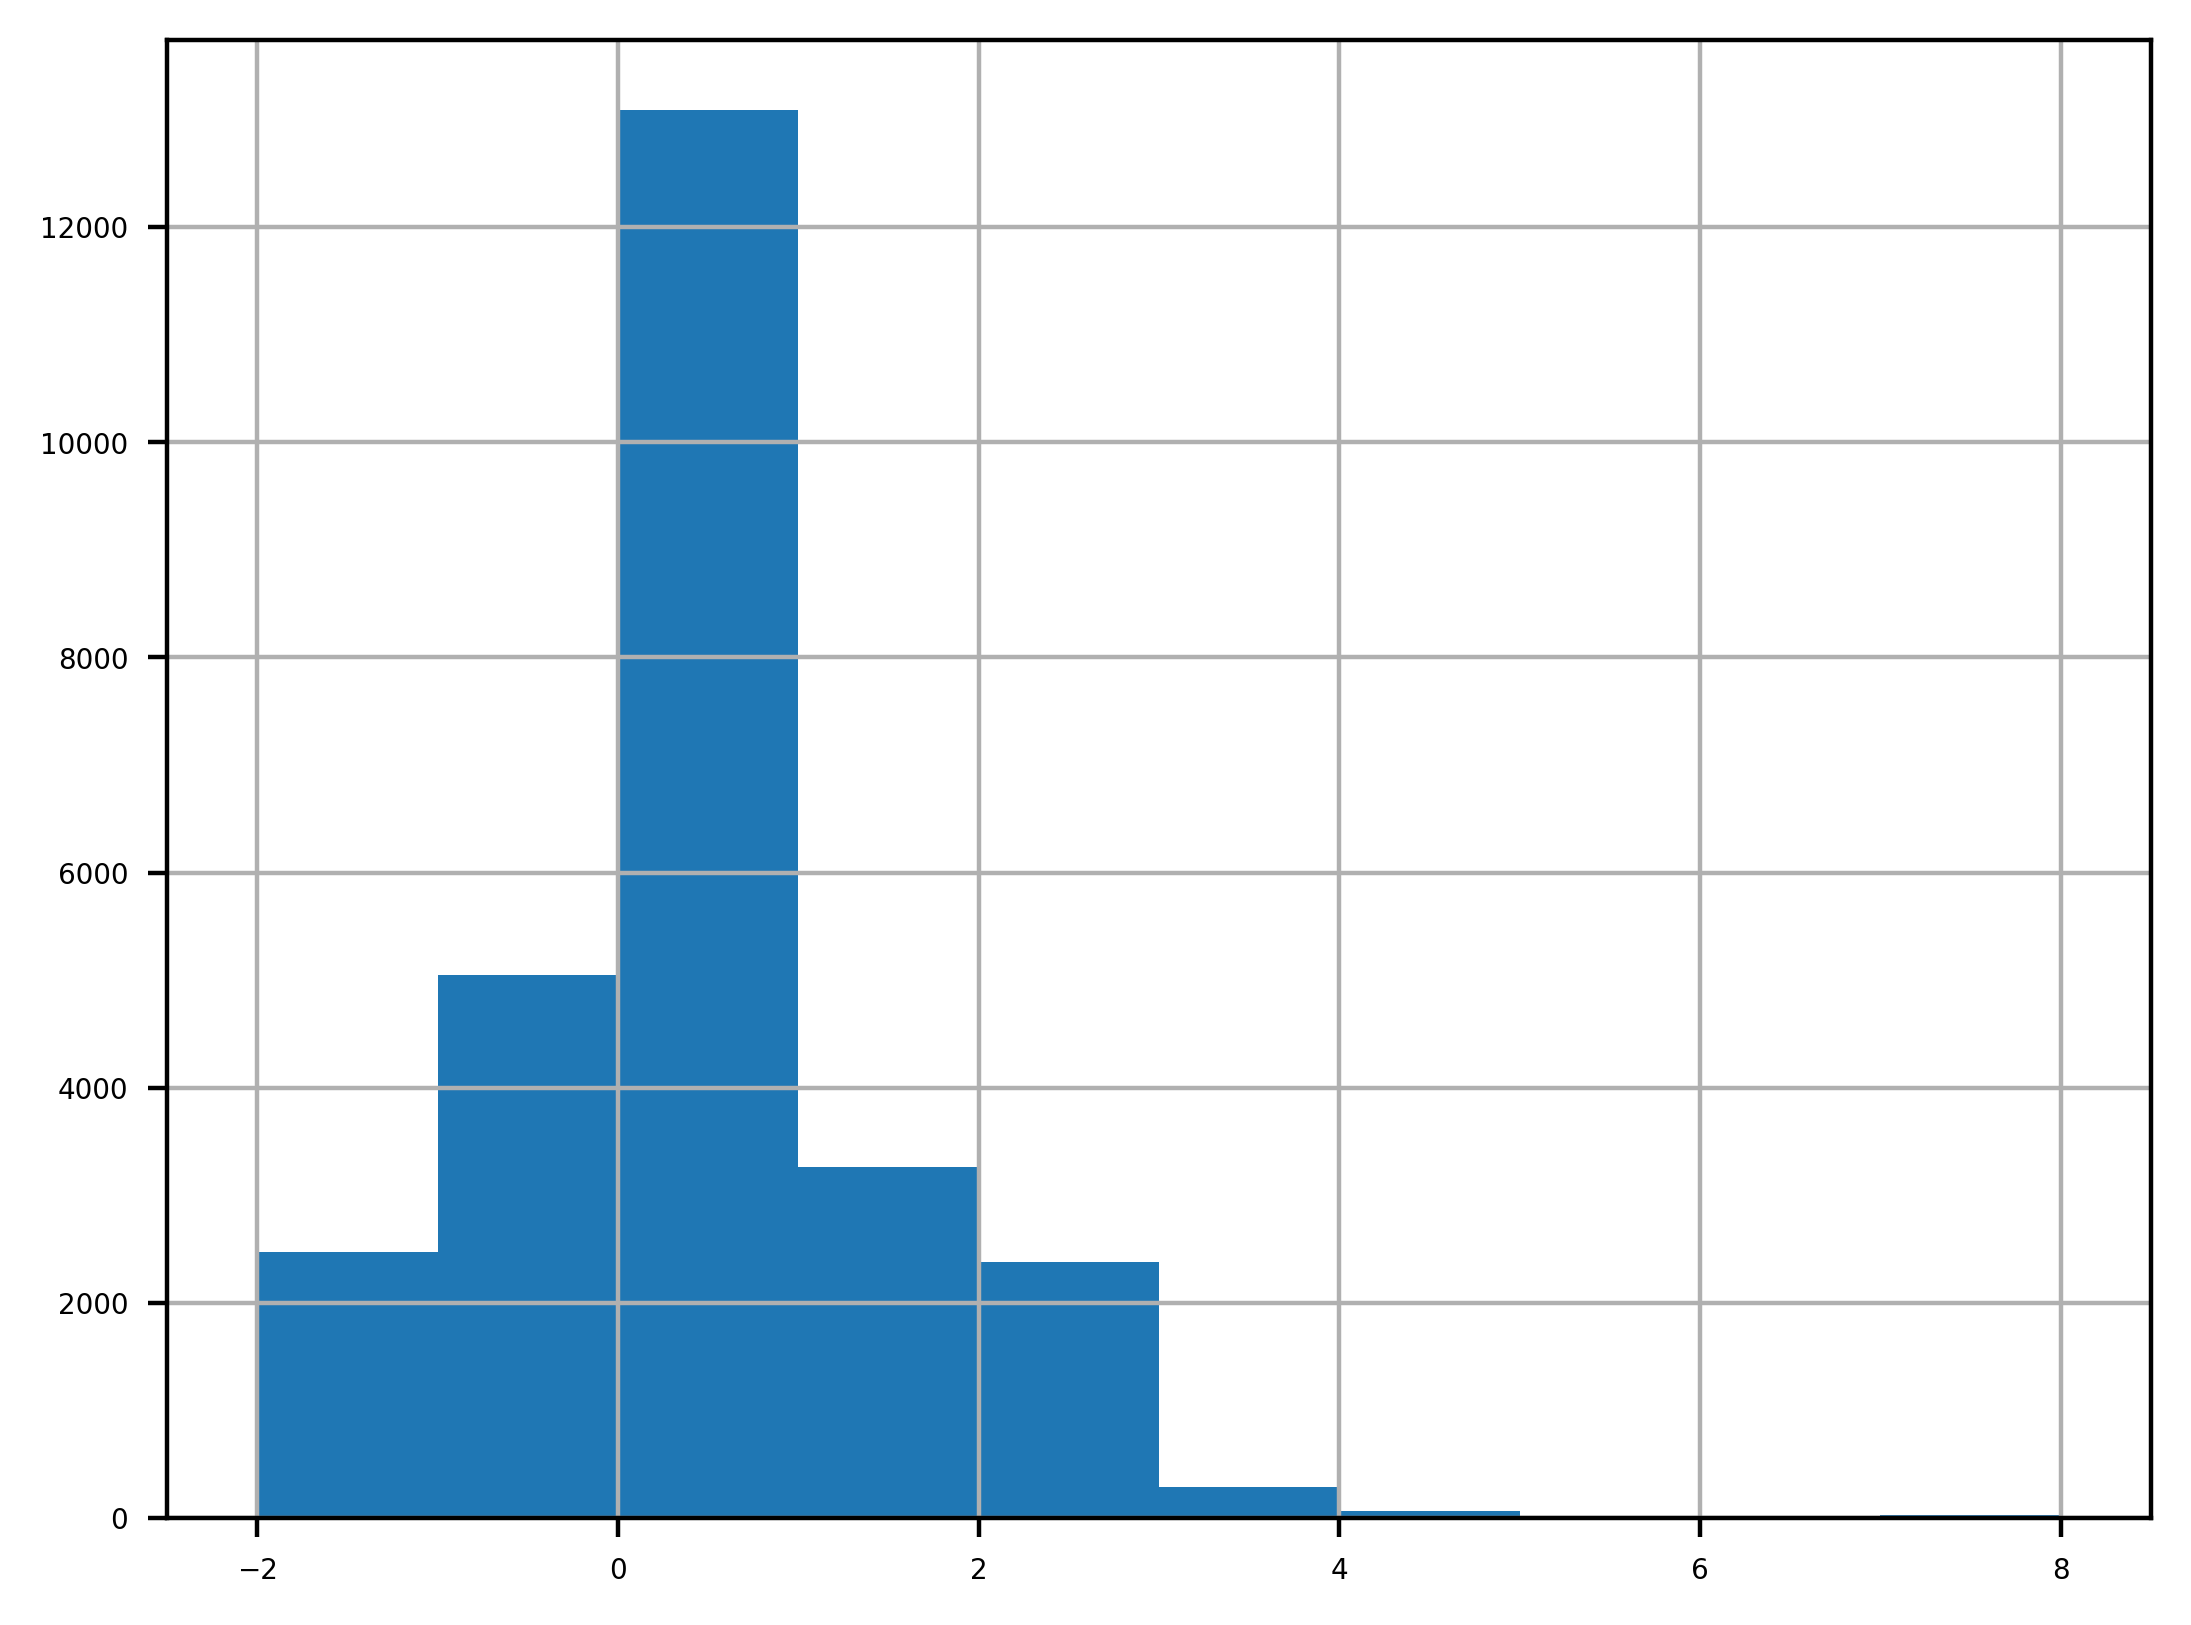

In [39]:
df[pay_feats[0]].hist();

<p>For better control over plot appearance, it is preferable to specify the bin edge locations. We will generate an array of 12 numbers, resulting in 11 bins, each centred around one of the unique values of <code>PAY_1</code>.</p>

In [40]:
pay_1_bins = np.array(range(-2,10)) - 0.5
pay_1_bins

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,
        8.5])

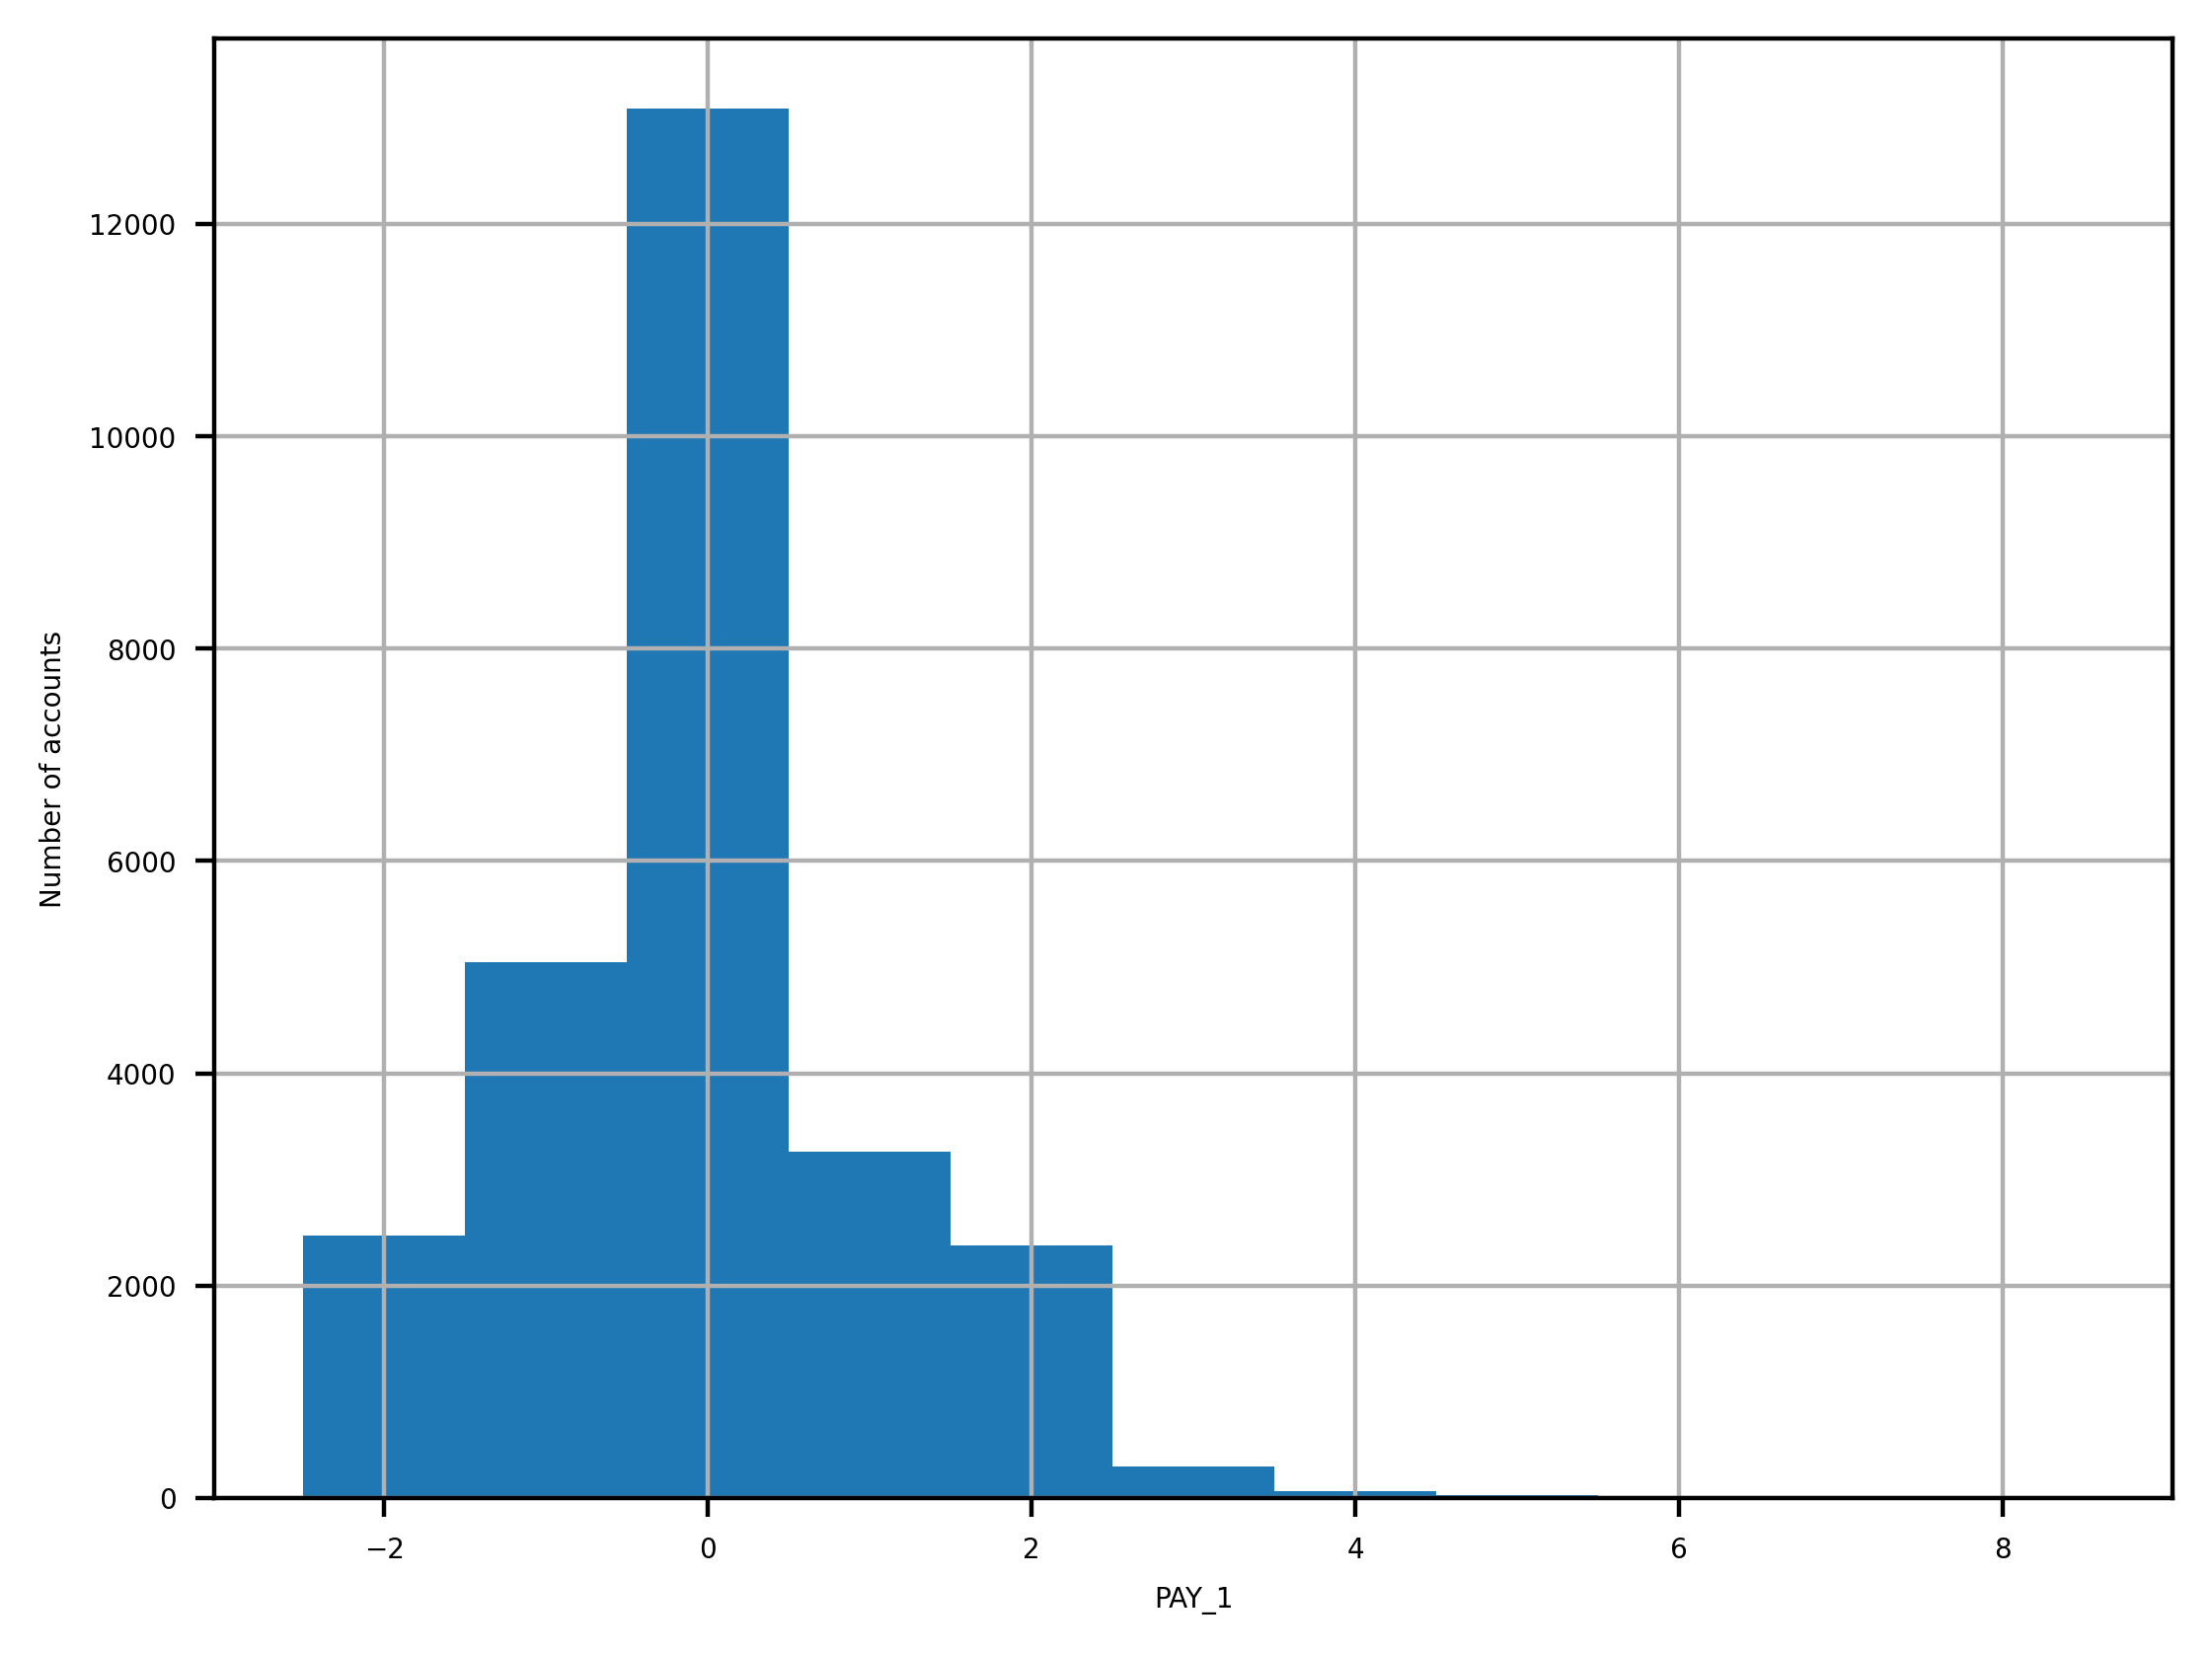

In [41]:
df[pay_feats[0]].hist(bins=pay_1_bins) # The bars are centred over the actual values in the data, and there is 1 bar per unique value.
plt.xlabel('PAY_1')
plt.ylabel('Number of accounts');

<p>Since we have looked at the value counts, we can confirm that most accounts are in good standing (values -2, -1, and 0). For those that aren't, it's more common for the "months late" to be a smaller number; likely, most people are paying off their balances before too long.</p>
<p>Now that we have established suitable histogram plotting styles let's use pandas to plot multiple histograms together and visualize the payment status features for the last six months.</p>

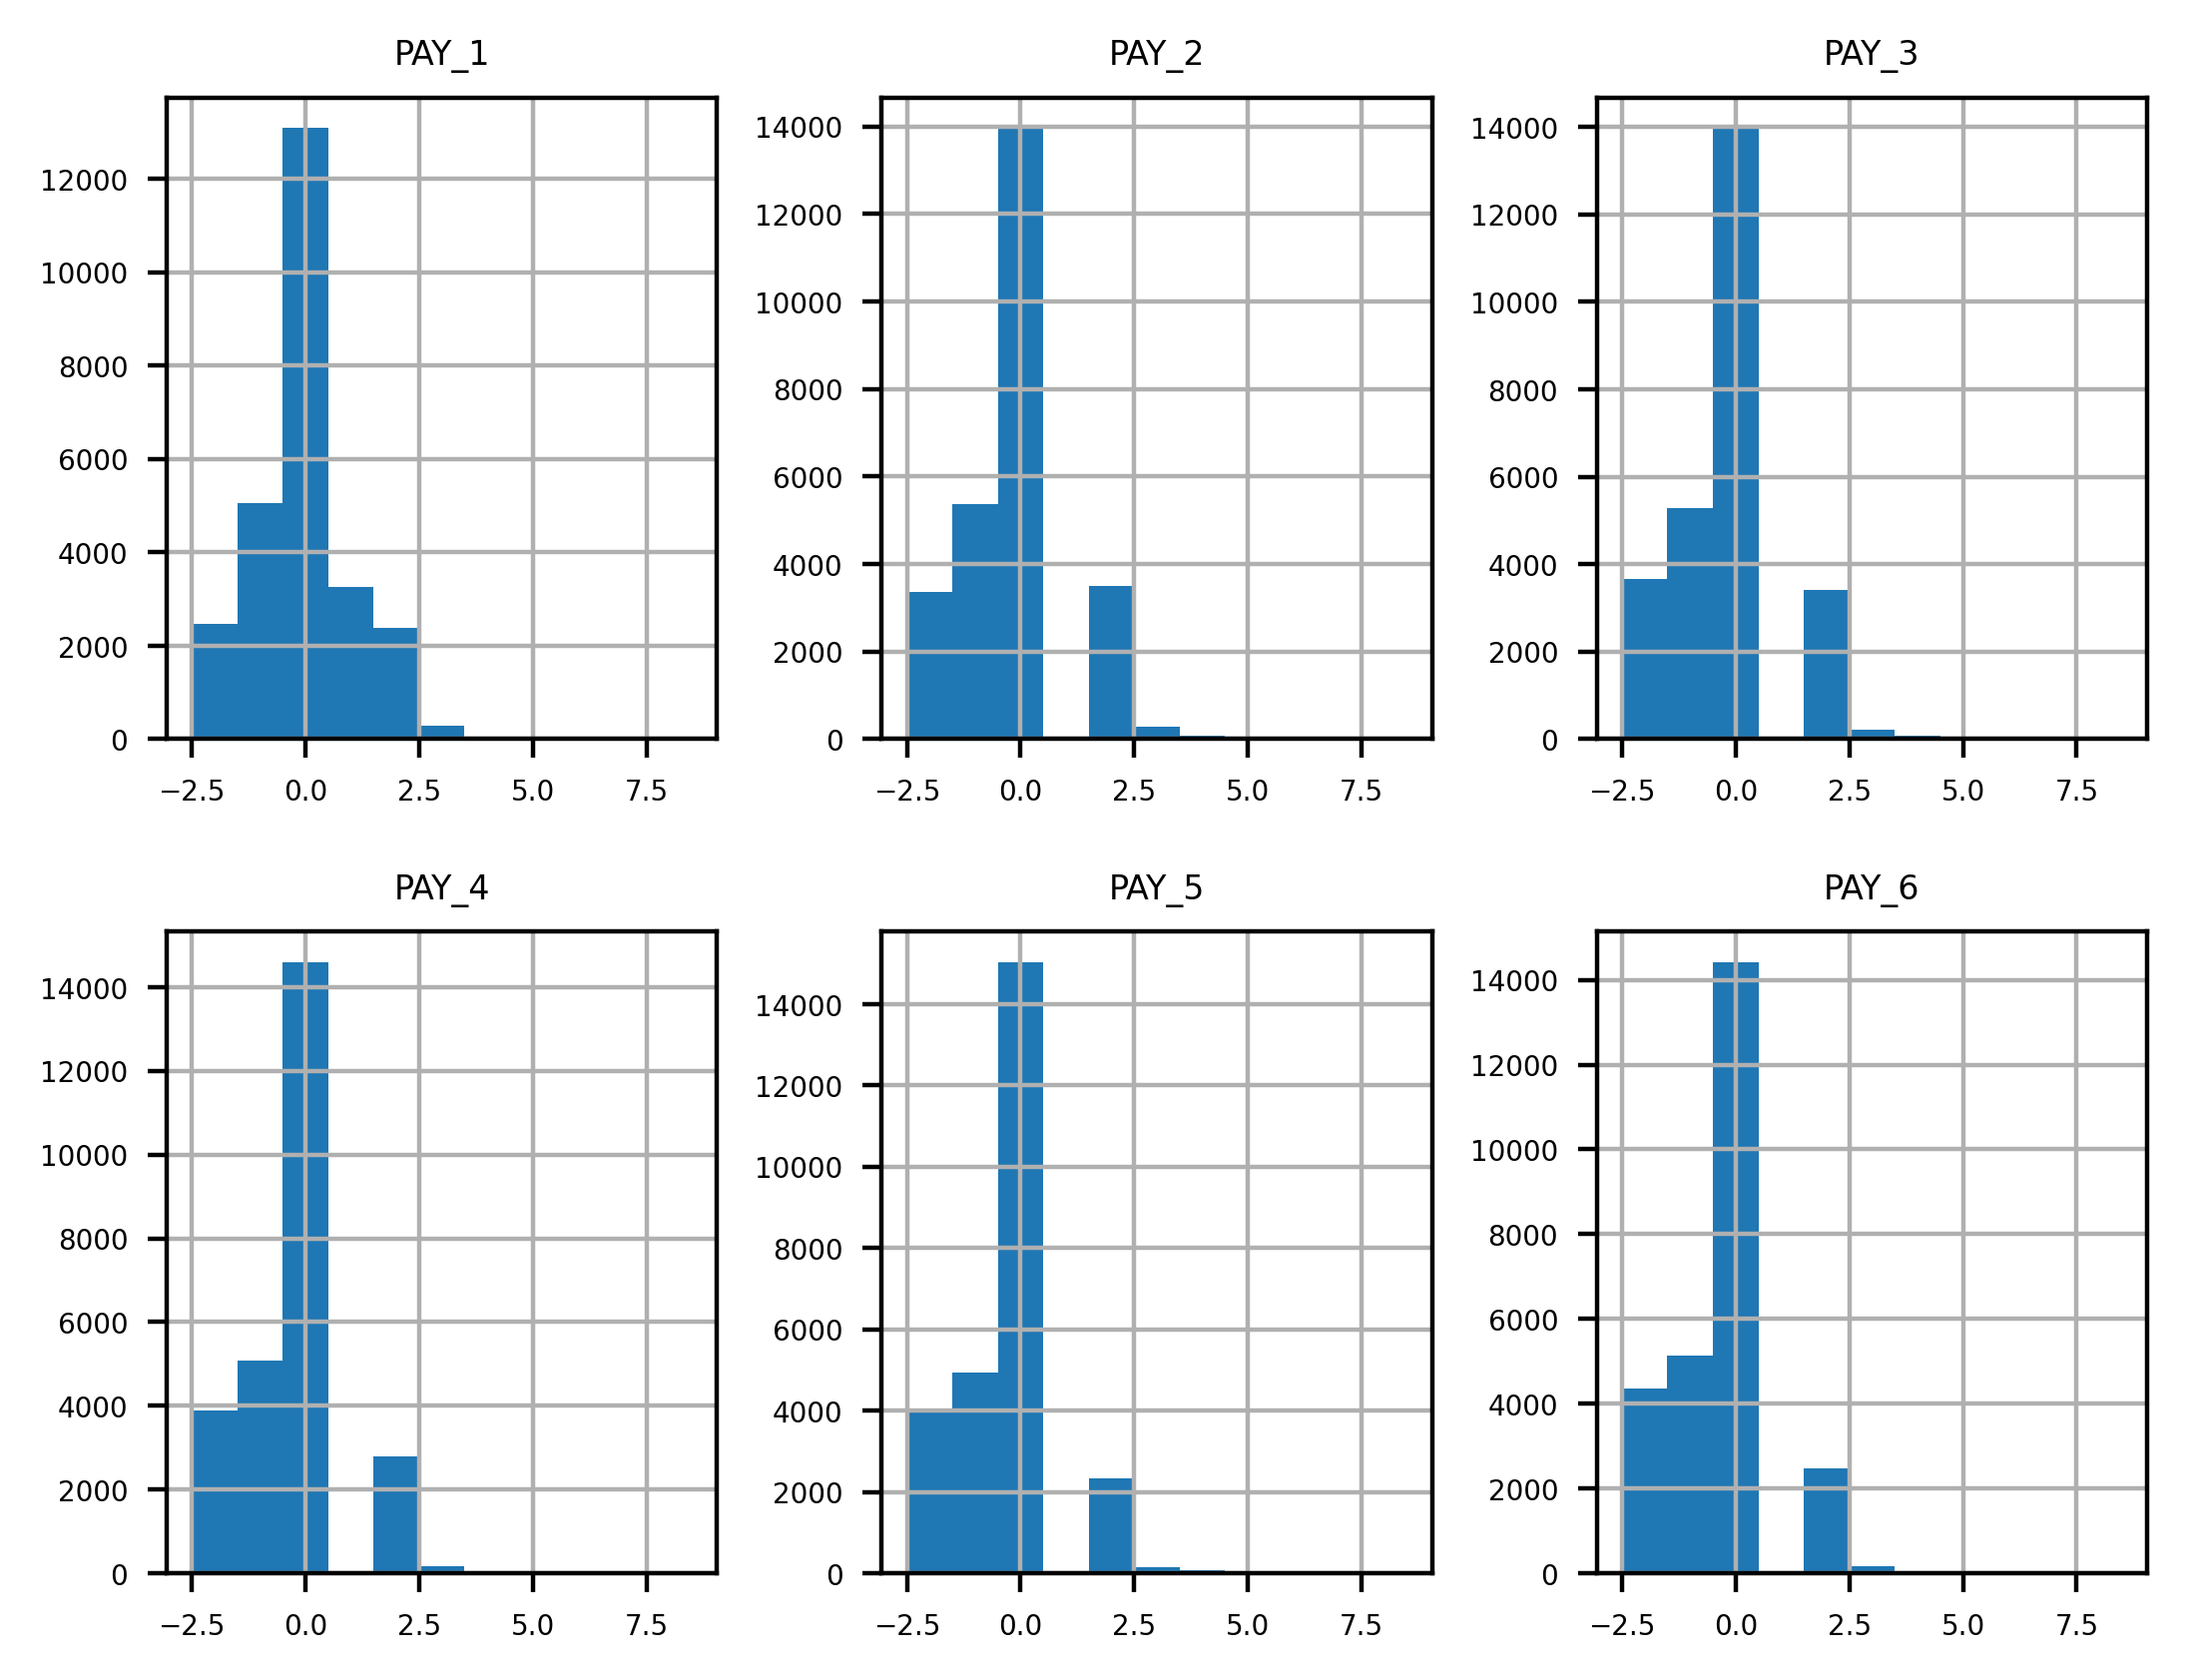

In [42]:
df[pay_feats].hist(bins=pay_1_bins, layout=(2,3)); # The y-axes are understood to be counts.

<p>Let's examine the values between July (<code>PAY_3</code>) and August (<code>PAY_2</code>). In July, very few accounts had a one-month payment delay; this bar is not really visible in the histogram. However, in August, there are suddenly thousands of accounts with a two-month payment delay. This does not make sense: the number of accounts with a two-month delay in a given month should be less than or equal to the number of accounts with a one-month delay in the previous month.</p>

In [43]:
df.loc[df['PAY_2']==2, ['PAY_2', 'PAY_3']].head()

,PAY_2,PAY_3
0,2,-1
1,2,0
13,2,2
15,2,0
47,2,2


<p>Accounts with a 2-month delay in August have nonsensical values for the July payment status. The only way to progress to a 2-month delay should be from a 1-month delay the previous month, yet none of these accounts indicate that.</p>
<p>We contacted our client to inquire about this issue. The client let us know that they had been having problems pulling the most recent month of data, leading to faulty reporting for accounts that had a 1-month delay in payment. In September, they mainly fixed these problems (although not entirely; that is why there were missing values in the <code>PAY_1</code> feature, as we found). So, in our dataset, the value of 1 is underreported in all months except for September (the <code>PAY_1</code> feature).</p>
<p>A predictive model depends on using the same type of data to make predictions as it was initially built with. This means we can include <code>PAY_1</code> as a feature in our model but not <code>PAY_2</code> or the other payment status features from previous months.</p>

In [44]:
# to create lists of feature names for the remaining financial features
bill_feats = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt_feats = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [45]:
df[bill_feats].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000,26664.000000
mean,51405.730723,49300.001500,47026.340047,43338.894539,40338.136701,38889.872337
std,73633.687106,70934.549534,68705.359524,64275.250740,60705.944083,59432.541657
min,-165580.000000,-69777.000000,-157264.000000,-170000.000000,-81334.000000,-339603.000000
25%,3580.000000,2999.750000,2627.250000,2341.750000,1745.000000,1256.000000
50%,22361.000000,21150.000000,20079.500000,19037.000000,18066.000000,17005.000000
75%,67649.750000,64395.500000,60360.000000,54727.500000,50290.500000,49253.750000
max,746814.000000,671563.000000,855086.000000,706864.000000,823540.000000,699944.000000


<p>The average monthly bill ranges from 40,000 to 50,000 NT dollars, which seems reasonable. There are some negative bill amounts, likely due to overpayment in the previous month.</p>

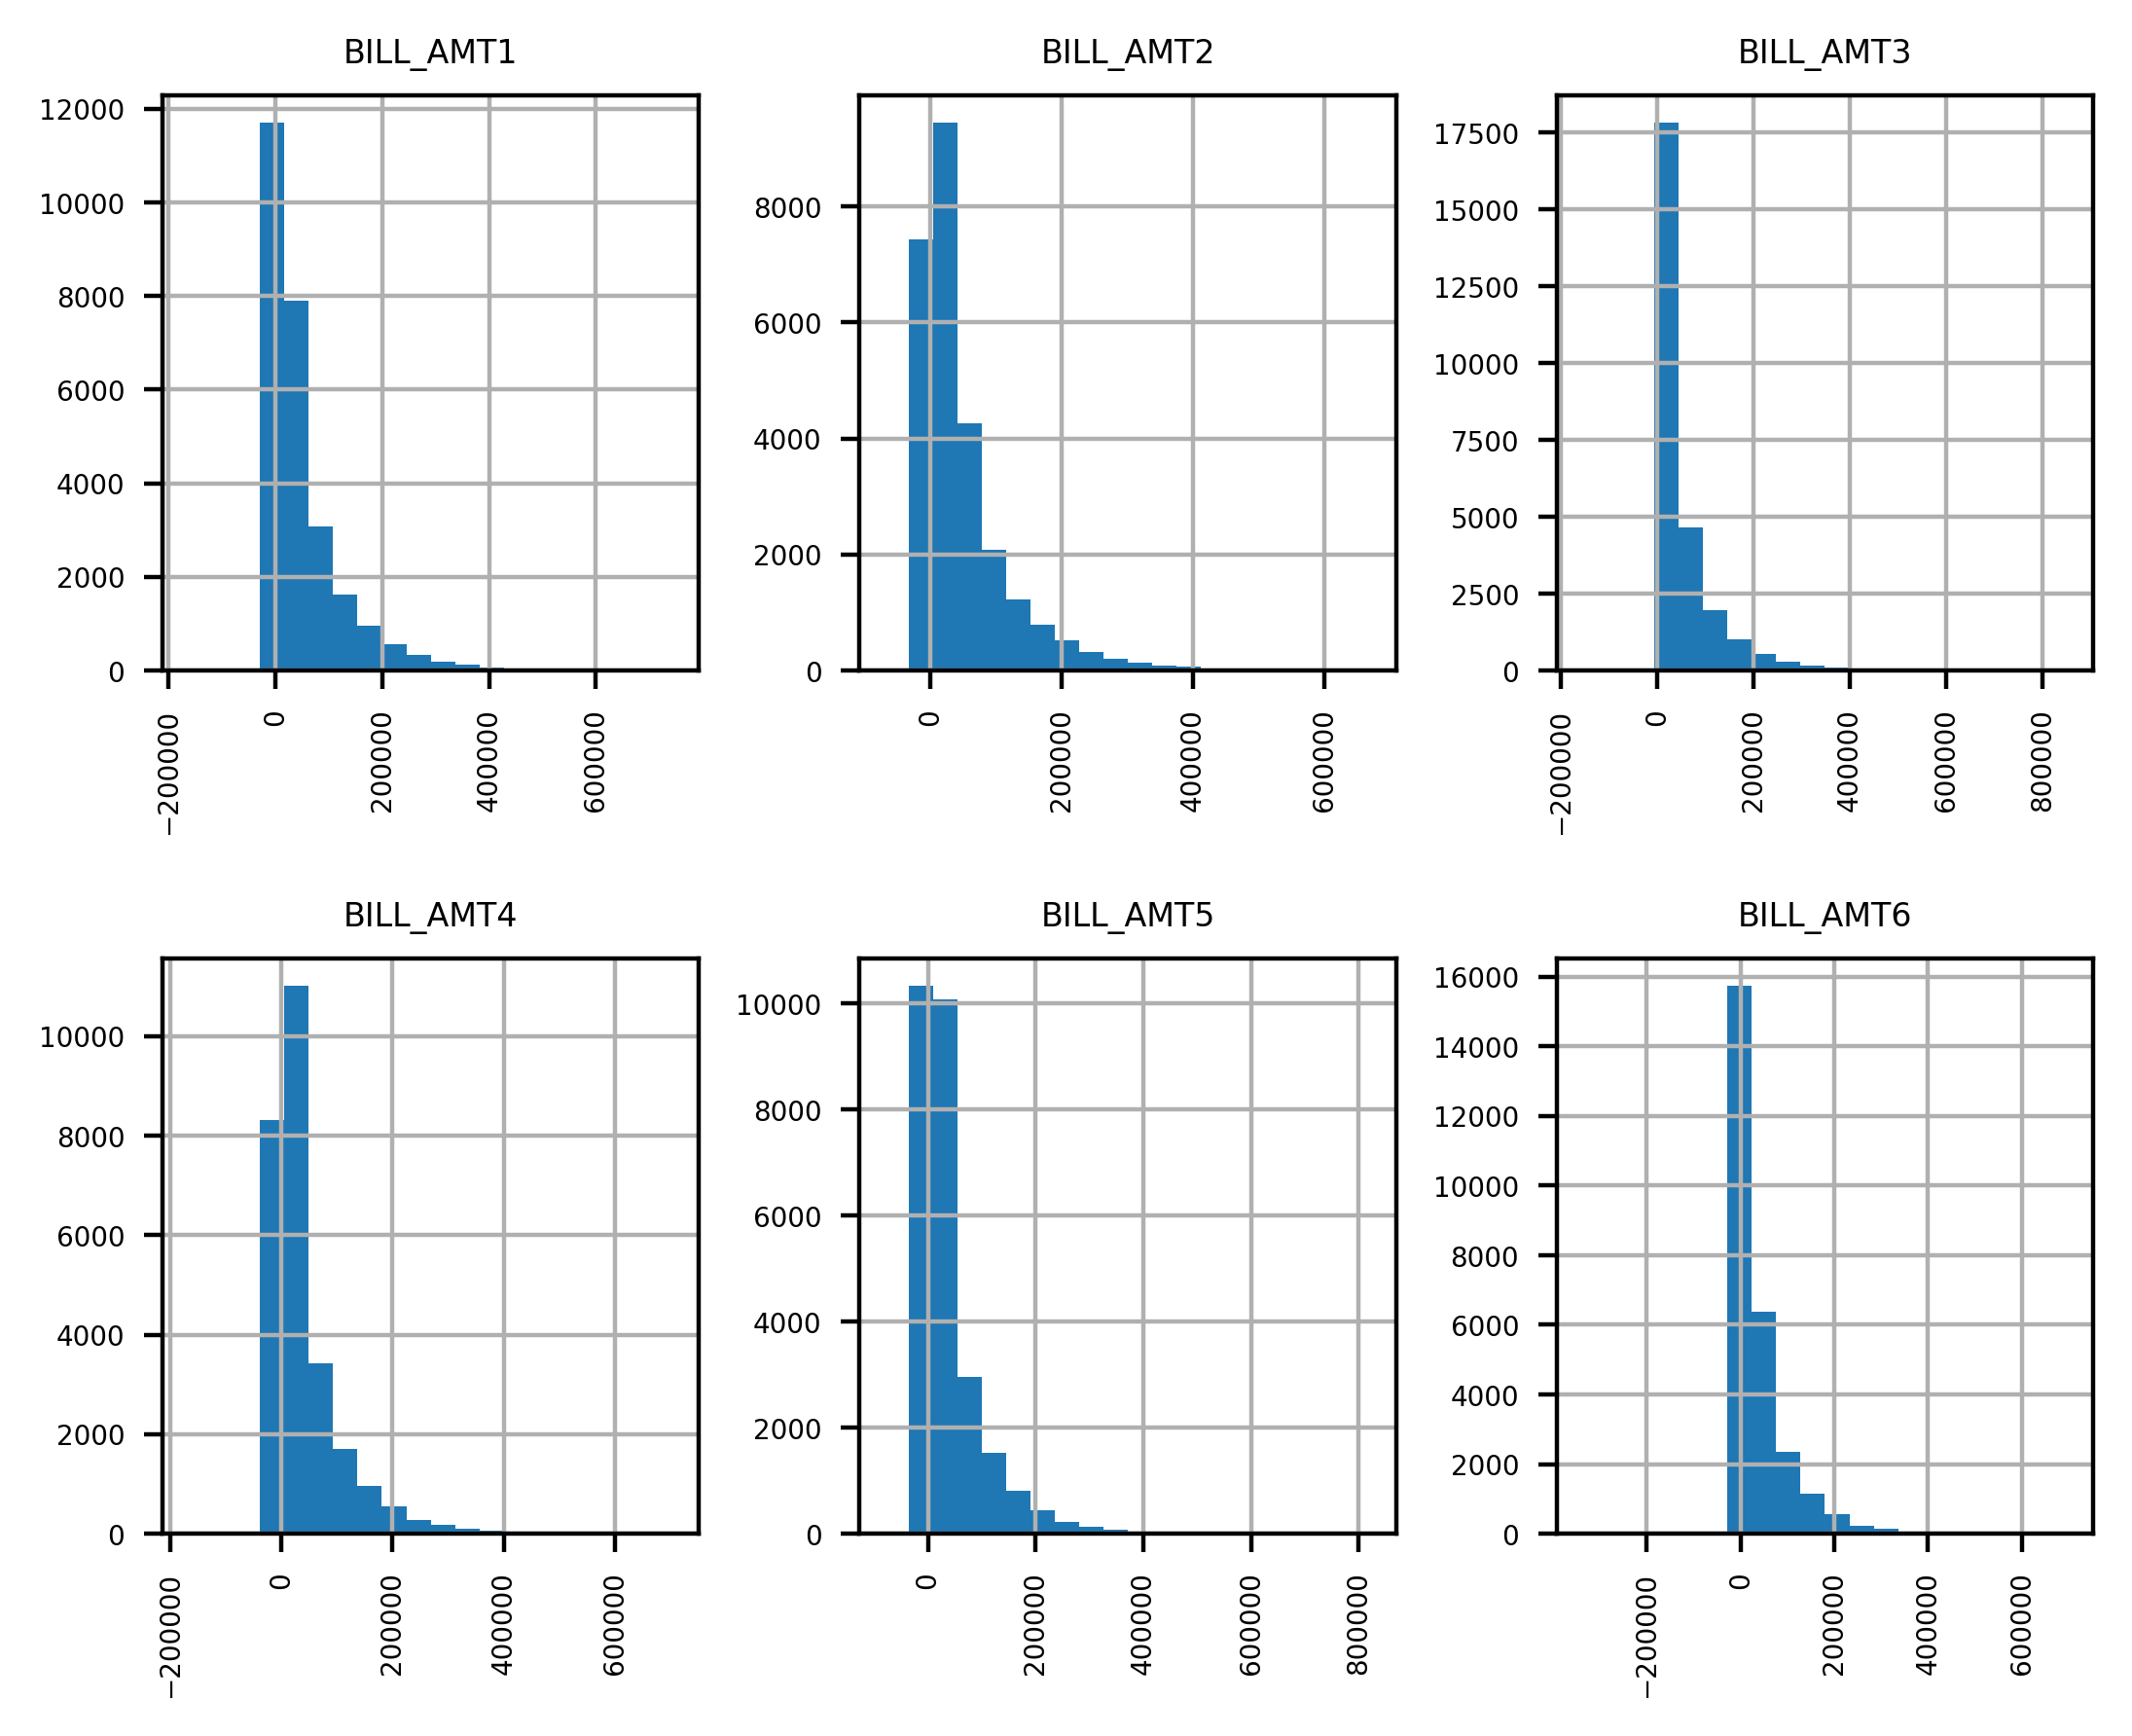

In [46]:
df[bill_feats].hist(bins=20, layout=(2,3), xrot=90)
plt.subplots_adjust(wspace=0.3, hspace=0.5);

<p>Most accounts have relatively small bills. The number of accounts decreases steadily as the bill amount increases. The distribution of billed amounts is roughly similar month to month, so we don't notice any data inconsistency issues as we did with the payment status features.</p>

In [47]:
df[pay_amt_feats].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,26664.000000,2.666400e+04,26664.000000,26664.000000,26664.000000,26664.000000
mean,5704.085771,5.881110e+03,5259.514964,4887.048717,4843.729973,5257.843047
std,16699.398632,2.121431e+04,17265.439561,15956.349371,15311.721795,17635.468185
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.020000e+02,390.000000,294.750000,242.750000,111.000000
50%,2114.500000,2.007000e+03,1822.000000,1500.000000,1500.000000,1500.000000
75%,5027.000000,5.000000e+03,4556.250000,4050.500000,4082.750000,4015.000000
max,873552.000000,1.227082e+06,889043.000000,621000.000000,426529.000000,528666.000000


<p>The average payment amounts are approximately ten times lower than the average bill amounts, suggesting that most accounts are not paying off their monthly balance. This aligns with our findings on the <code>PAY_1</code> feature, where the most common value was 0, indicating that the account made at least the minimum payment but did not pay off the entire balance. There are no negative payments.</p>

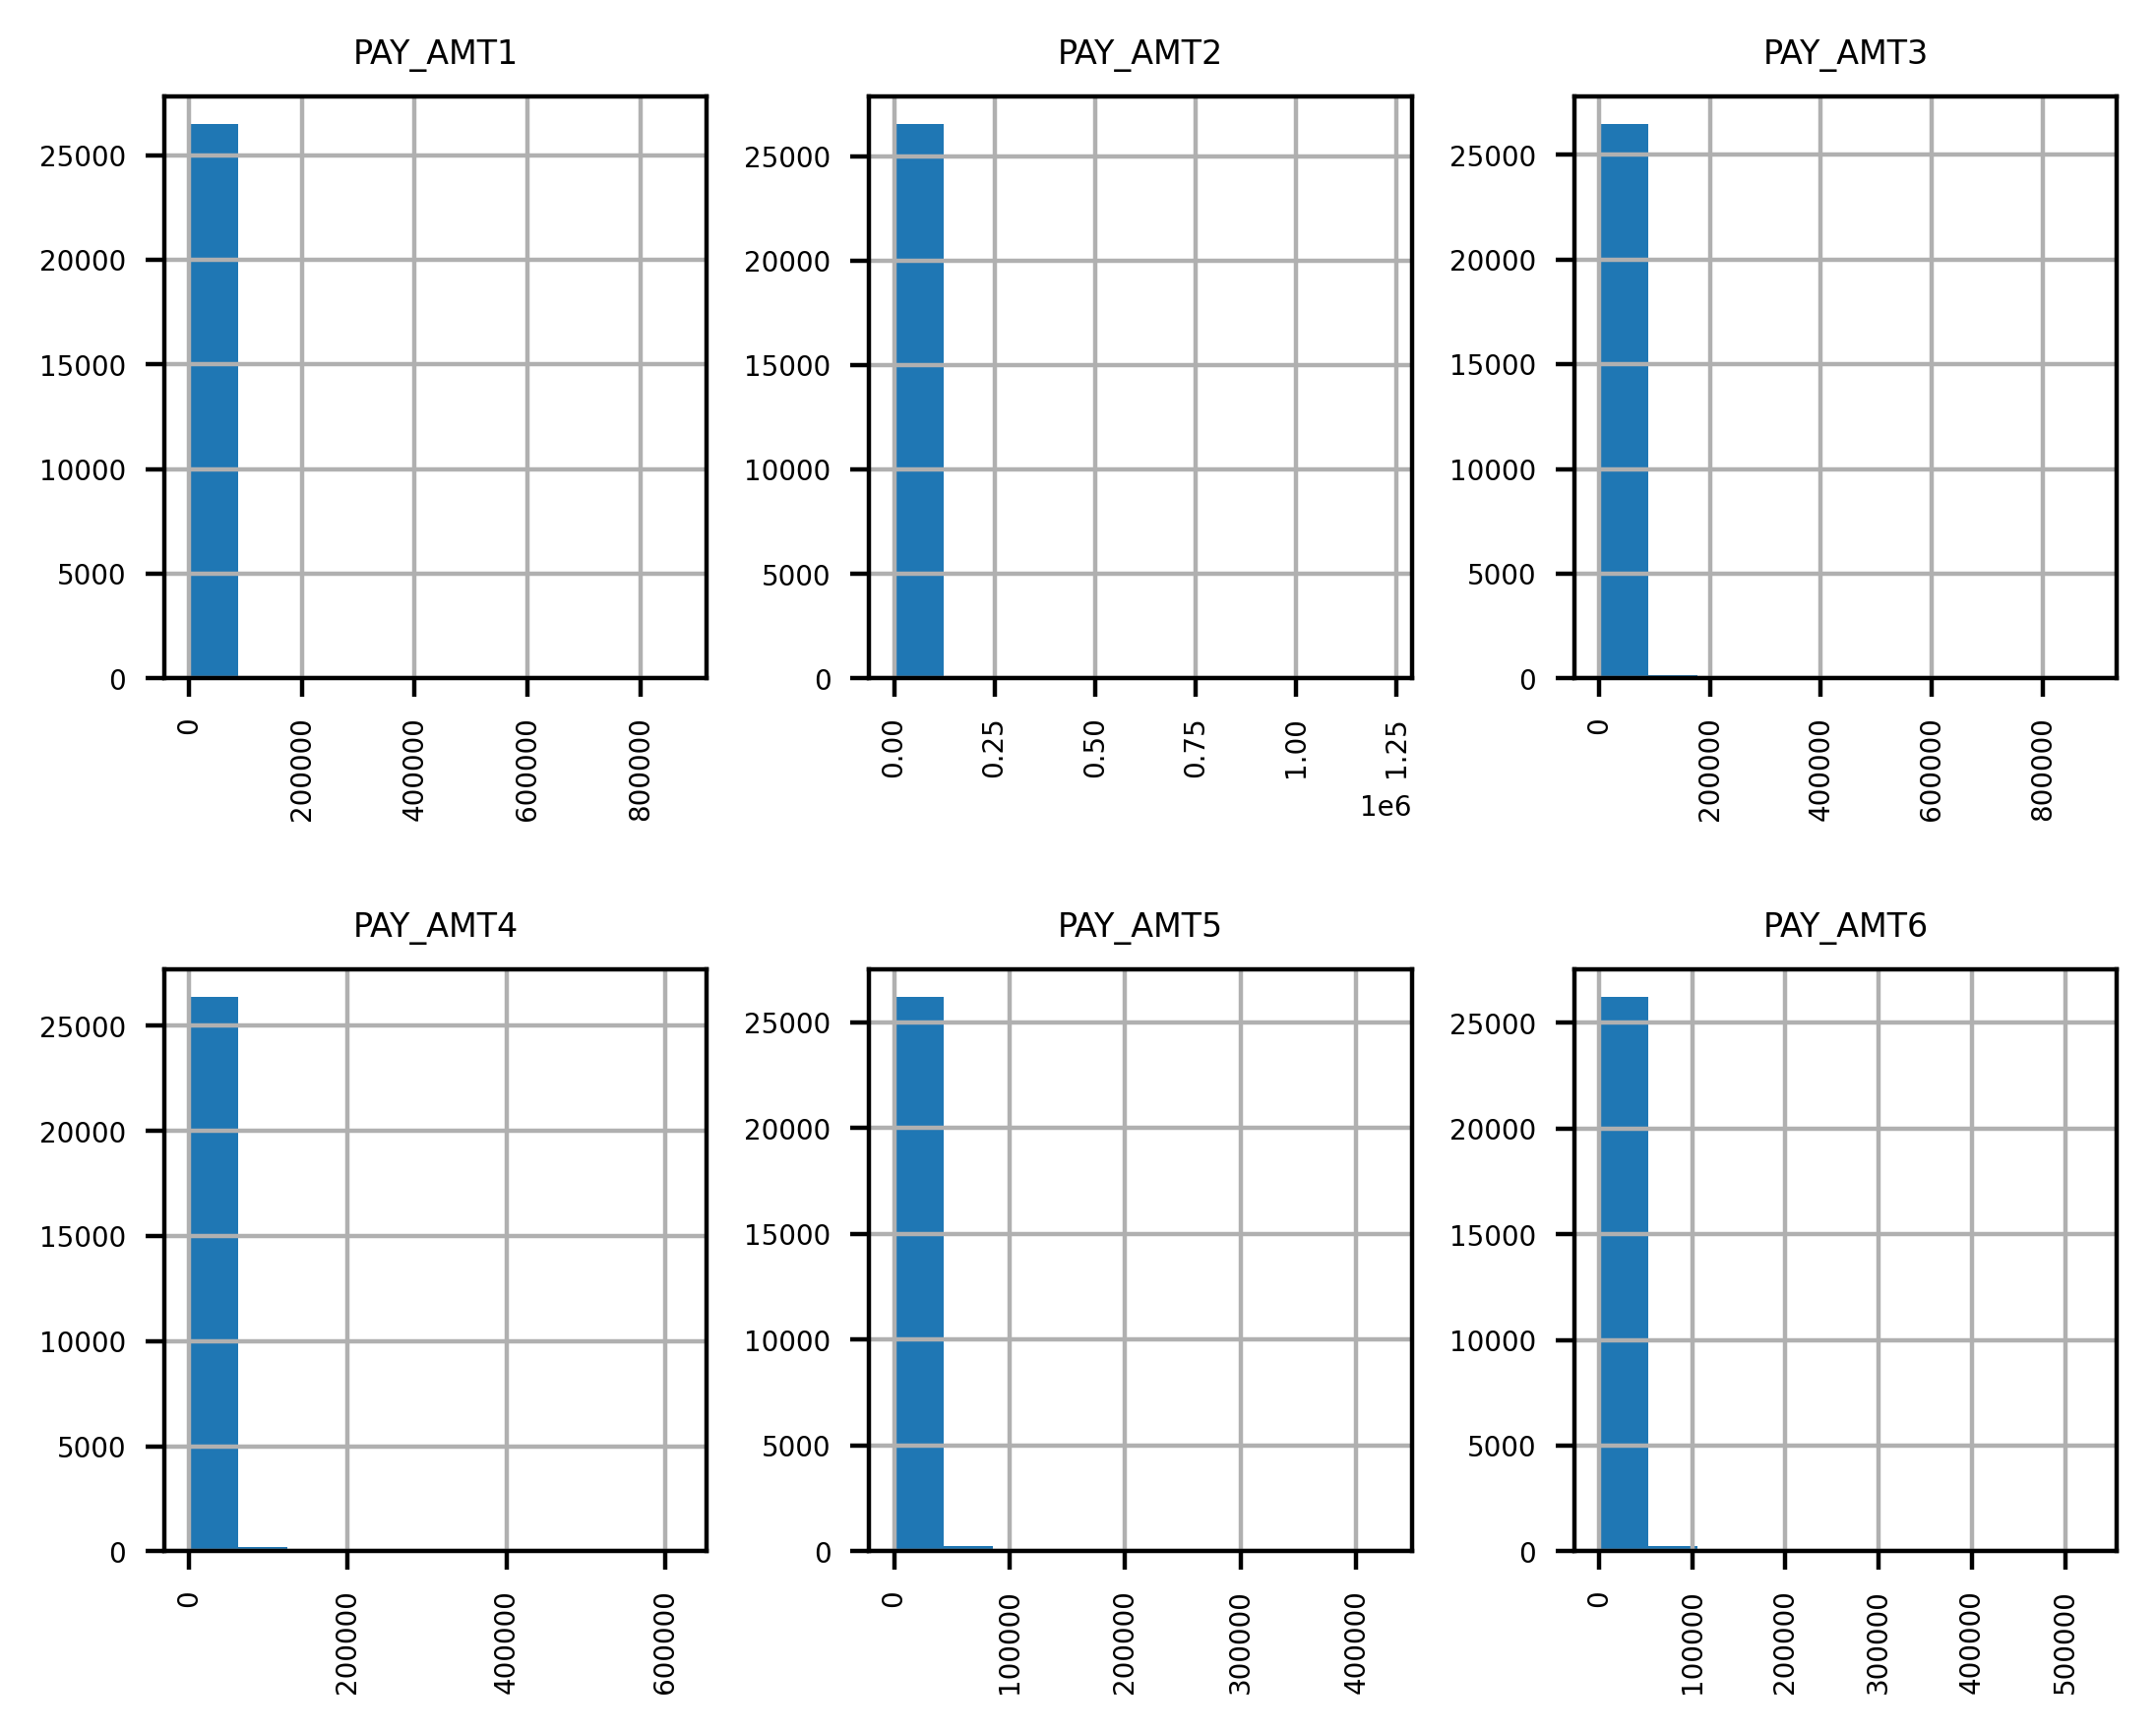

In [48]:
df[pay_amt_feats].hist(layout=(2,3), xrot=90)
plt.subplots_adjust(wspace=0.3, hspace=0.5);

<p>The graphic could be more informative as most histograms only have one noticeable peak. Most of the monthly payment amounts fall into a single bin, including the value 0. How many payments are 0? </p>

In [49]:
pay_zero_mask = df[pay_amt_feats] == 0
pay_zero_mask.sum()

PAY_AMT1    4656
PAY_AMT2    4833
PAY_AMT3    5293
PAY_AMT4    5697
PAY_AMT5    5981
PAY_AMT6    6373
dtype: int64

<p>In any given month, a significant portion, roughly around 20-25% of accounts, have a bill payment equal to 0. However, most bill payments are above 0. So, why can't we see them in the histogram? This is due to the range of values for bill payments relative to the values of most of the bill payments. The statistical summary shows that the maximum monthly bill payment is typically 100 times larger than the average bill payment. There are likely only a small number of these vast bill payments. But, because of the way the histogram is created using equal-sized bins, nearly all the data is lumped into the smallest bin, and the larger bins are almost invisible because they have so few accounts. We need a strategy to visualize this data effectively.</p>

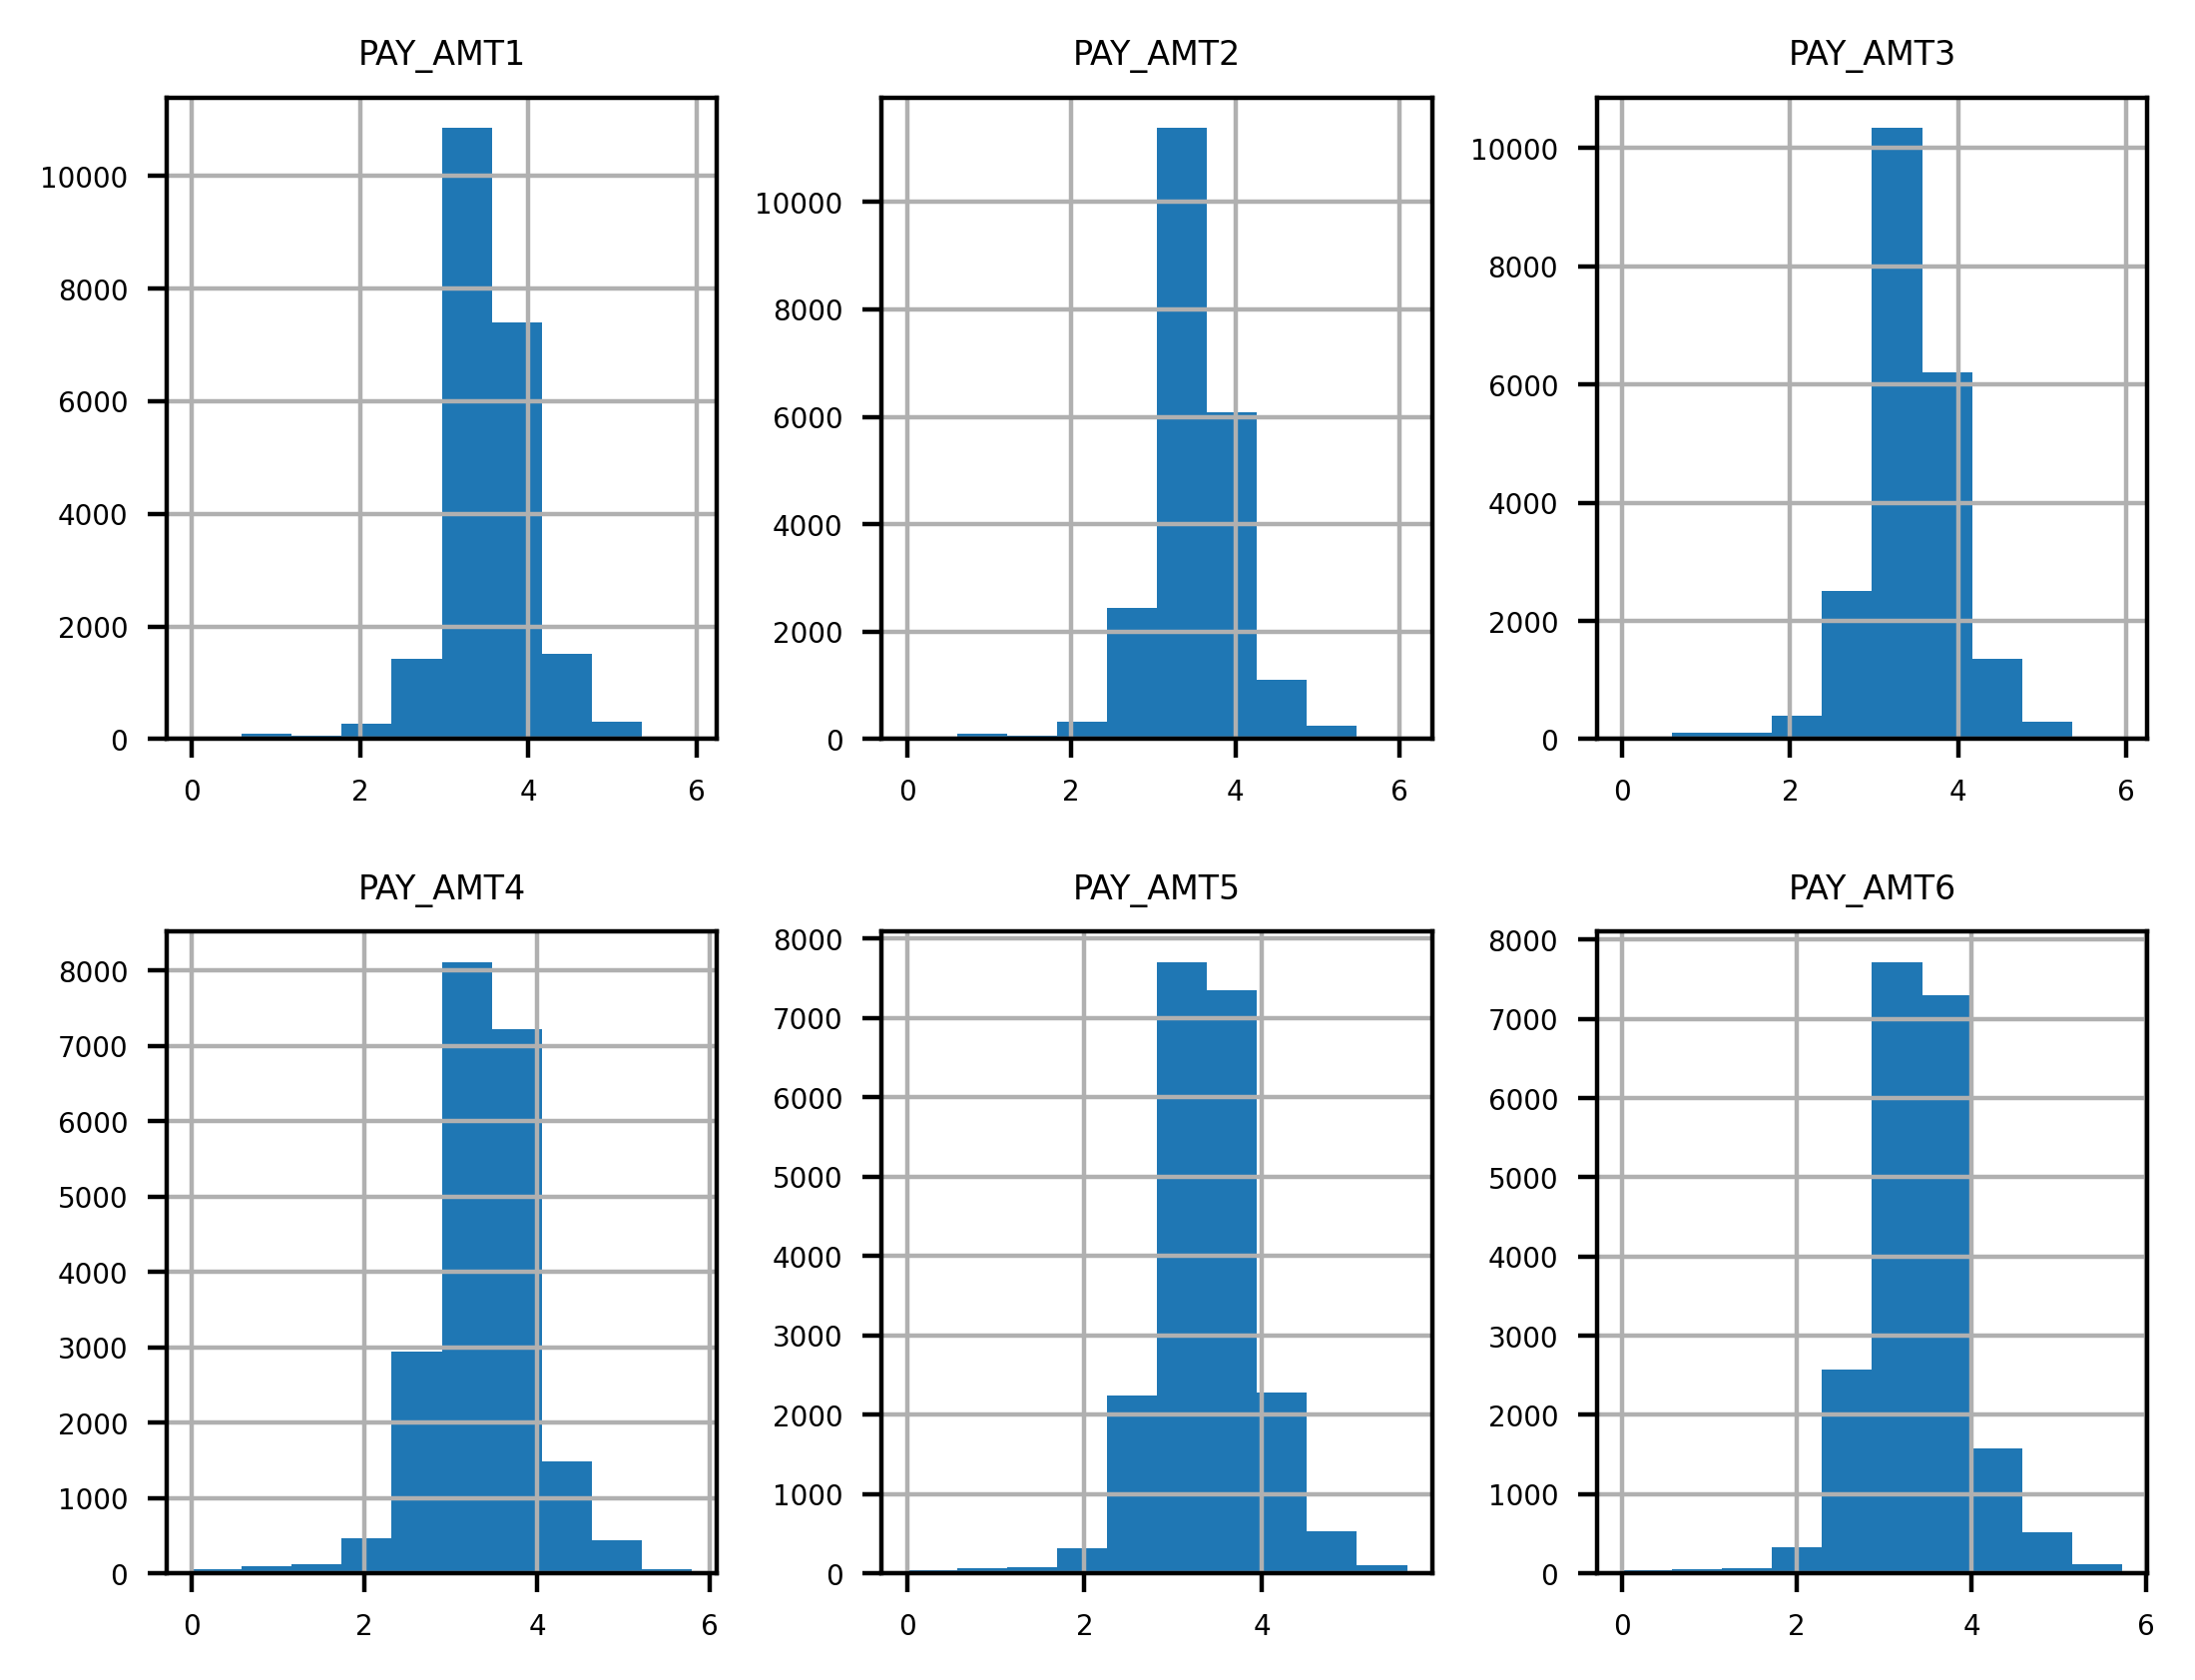

In [50]:
# You can use .apply() to apply any function, including log10, to all the elements of a DataFrame.

df[pay_amt_feats][~pay_zero_mask].apply(np.log10).hist(layout=(2,3));

<p>The result is a more effective data visualization: the values are spread in a more informative way across the histogram bins. We can see that the most commonly occurring bill payments are in the range of thousands (log10(1,000) = 3), which matches what we observed for the mean bill payment in the statistical summary. There are some small bill payments and also a few large ones. Overall, the distribution of bill payments appears consistent from month to month, so we don't see any potential issues with this data.</p>
<p>The primary factor to consider in evaluating the response of a binary classification problem is the proportion of the positive class (<code>default payment next month</code> = 1).</p>

In [51]:
df['default payment next month'].mean()

0.2217971797179718

In [52]:
df.groupby('default payment next month')['ID'].count()

default payment next month
0    20750
1     5914
Name: ID, dtype: int64

<p>Since the target variable is 1 or 0, taking the mean of this column indicates the fraction of accounts that defaulted: 22%. While our data is not strictly balanced, we also note that a positive class fraction of 22% is not particularly imbalanced.</p>

<h2>Examining the Relationships Between Features and the Response Variable</h2>

In [53]:
features_response = df.columns.tolist()
features_response

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'EDUCATION_CAT',
 'graduate school',
 'high school',
 'others',
 'university']

In [54]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'others', 'university']
features_response = [item for item in features_response if item not in items_to_remove]
features_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

<p>Features that are highly correlated to the response will be good features to use for prediction.</p>

In [55]:
corr = df[features_response].corr()
corr

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
LIMIT_BAL,1.000000,-0.232688,-0.111873,0.149157,-0.273396,0.287009,0.279289,0.285299,0.294342,0.295198,0.289818,0.194820,0.188049,0.207638,0.202795,0.218082,0.221305,-0.154423
EDUCATION,-0.232688,1.000000,-0.137097,0.179035,0.112653,0.016156,0.012307,0.007683,-0.005862,-0.013174,-0.012670,-0.040092,-0.033610,-0.042349,-0.039319,-0.044946,-0.046859,0.034966
MARRIAGE,-0.111873,-0.137097,1.000000,-0.412828,0.019759,-0.028610,-0.026009,-0.029192,-0.027740,-0.029895,-0.024414,-0.002951,-0.007548,-0.003408,-0.014387,-0.000410,-0.009461,-0.026030
AGE,0.149157,0.179035,-0.412828,1.000000,-0.044277,0.056245,0.054099,0.054107,0.051241,0.049701,0.047519,0.025437,0.025421,0.029876,0.025307,0.020541,0.021640,0.014334
PAY_1,-0.273396,0.112653,0.019759,-0.044277,1.000000,0.185826,0.188799,0.181257,0.178812,0.180438,0.177486,-0.081450,-0.073295,-0.072682,-0.064112,-0.057021,-0.061031,0.325365
BILL_AMT1,0.287009,0.016156,-0.028610,0.056245,0.185826,1.000000,0.951651,0.900386,0.860149,0.828615,0.802008,0.138221,0.112460,0.145635,0.160204,0.163425,0.178943,-0.020508
BILL_AMT2,0.279289,0.012307,-0.026009,0.054099,0.188799,0.951651,1.000000,0.937488,0.892103,0.858078,0.830300,0.276583,0.114473,0.137514,0.148685,0.153851,0.172472,-0.014579
BILL_AMT3,0.285299,0.007683,-0.029192,0.054107,0.181257,0.900386,0.937488,1.000000,0.930385,0.889186,0.855154,0.242809,0.287837,0.119456,0.141010,0.159446,0.178121,-0.014649
BILL_AMT4,0.294342,-0.005862,-0.027740,0.051241,0.178812,0.860149,0.892103,0.930385,1.000000,0.937799,0.899241,0.229123,0.217716,0.293652,0.131700,0.158633,0.171339,-0.011349
BILL_AMT5,0.295198,-0.013174,-0.029895,0.049701,0.180438,0.828615,0.858078,0.889186,0.937799,1.000000,0.945671,0.212053,0.189566,0.241291,0.296192,0.140669,0.161847,-0.006753


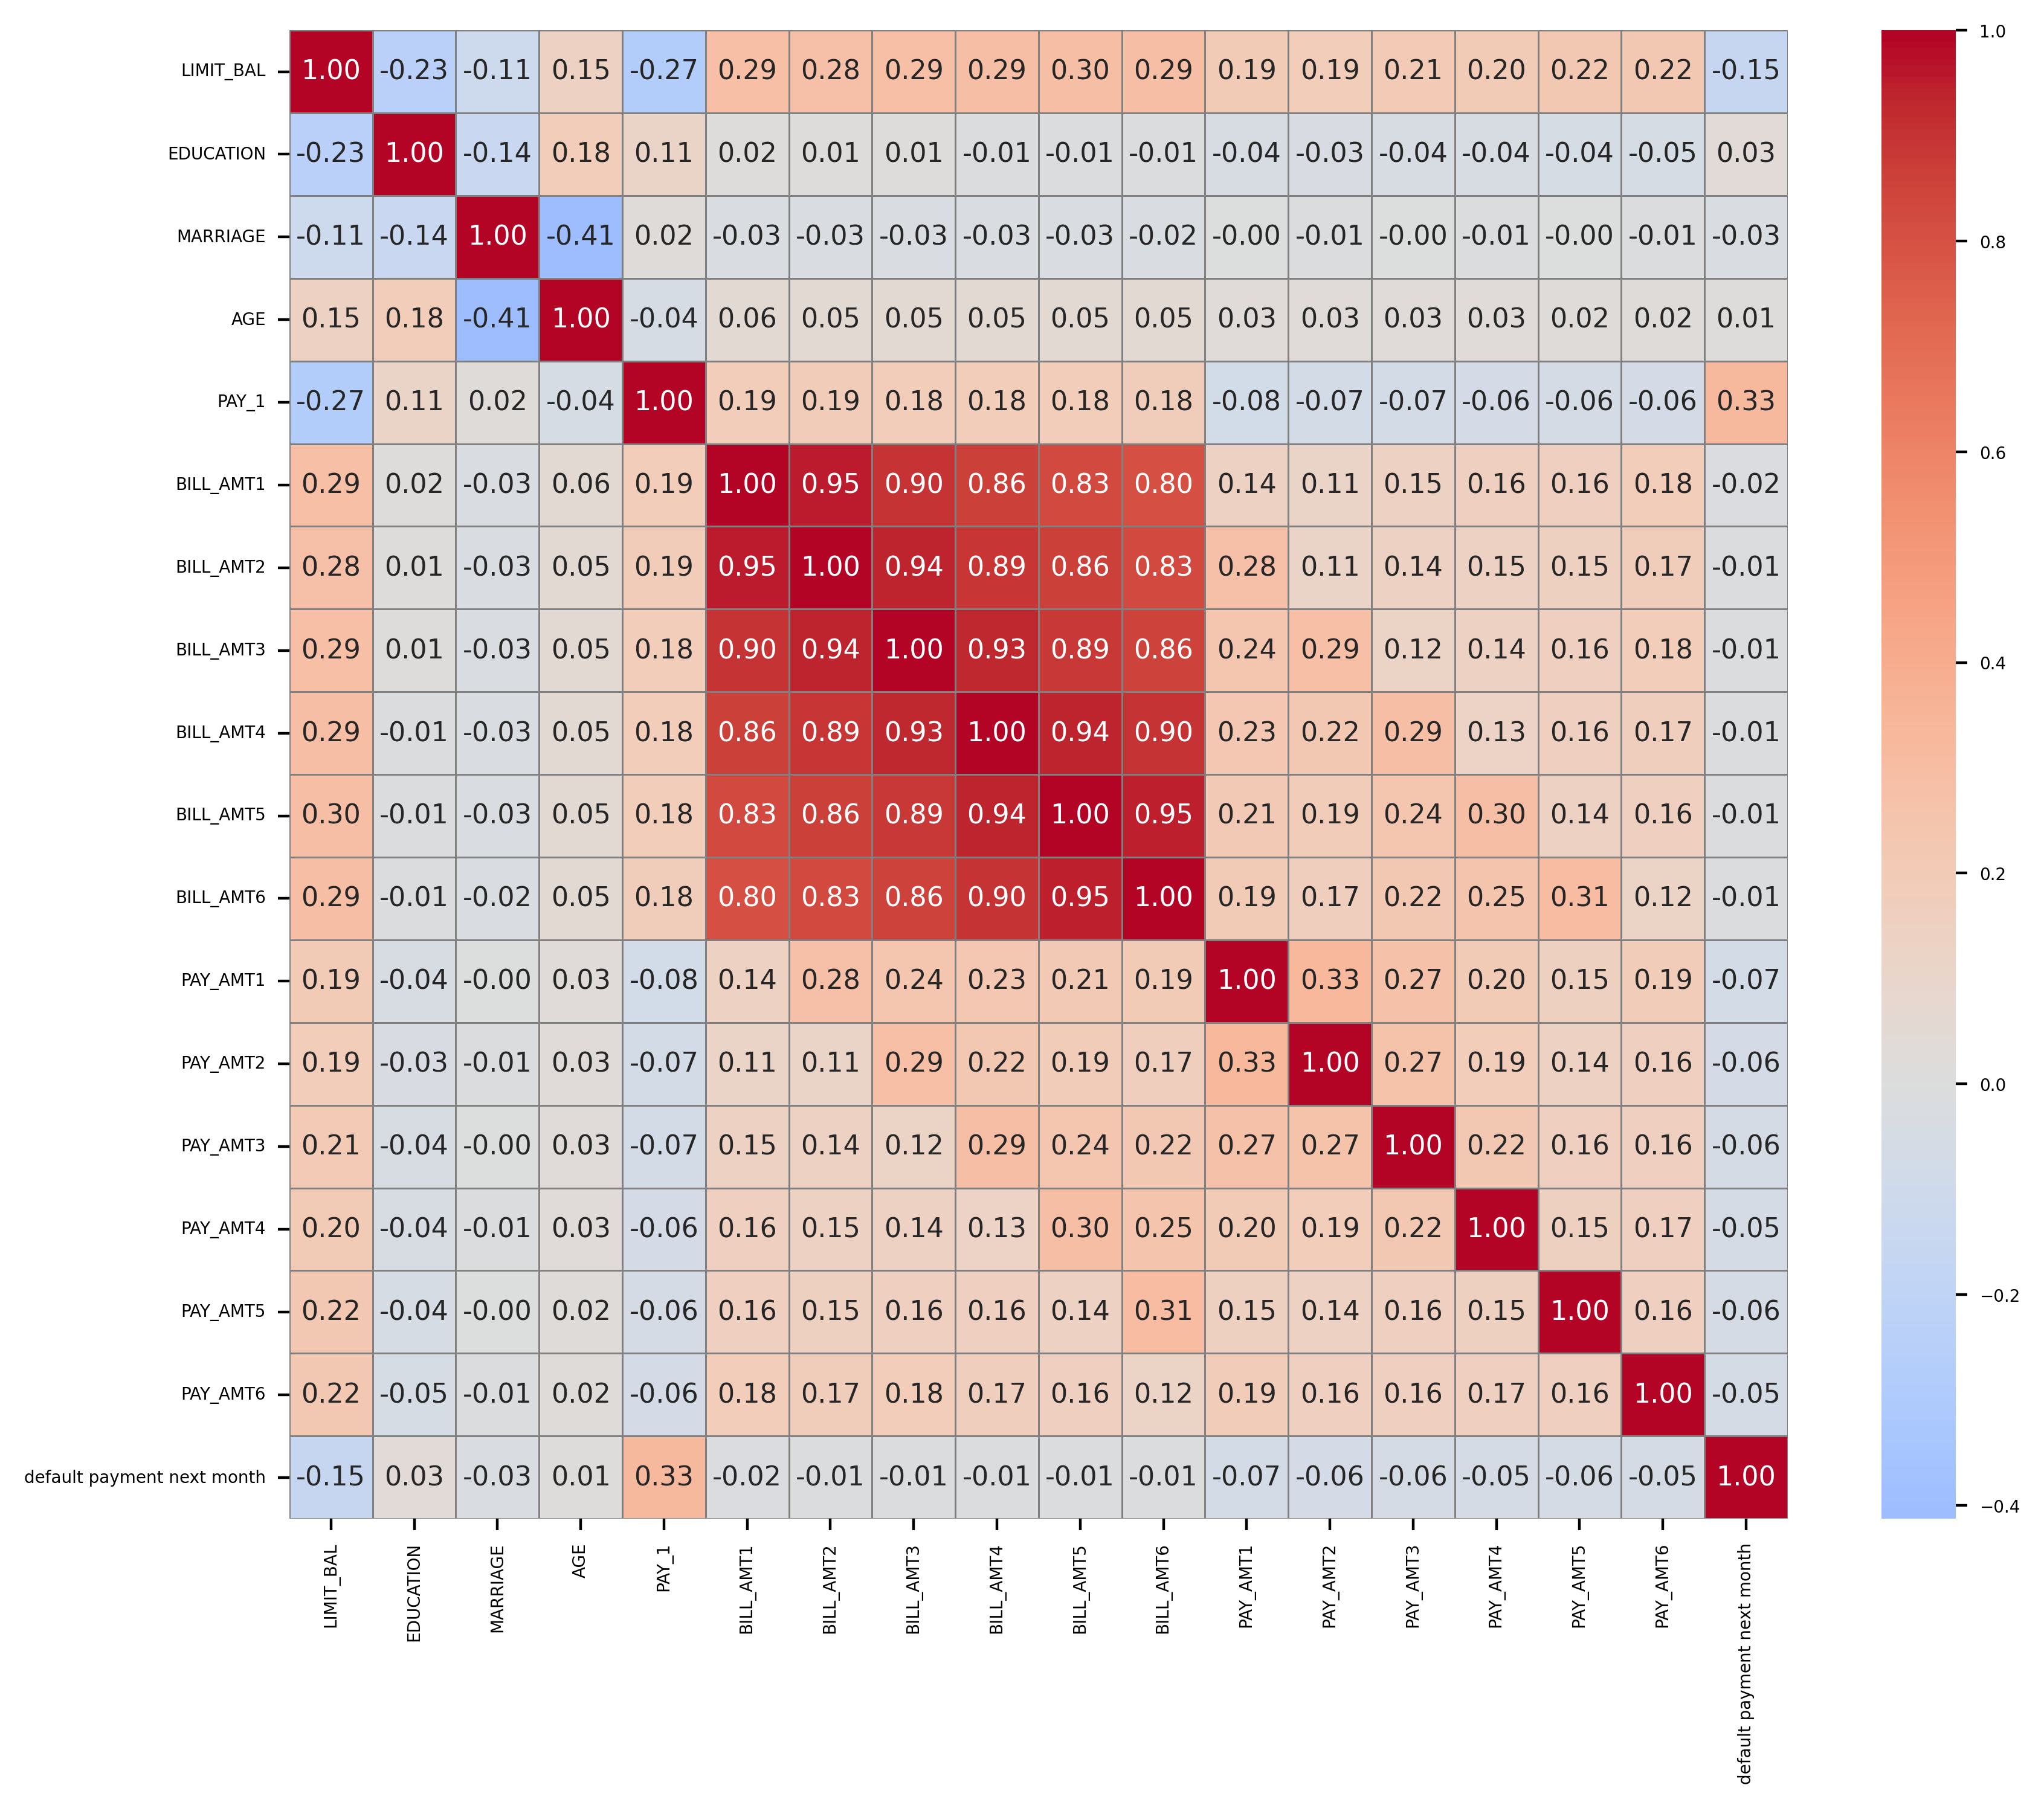

In [56]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f',
            annot_kws={'size': 8},
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0, cmap='coolwarm', linewidths=0.5, linecolor='gray');

<p>The <code>PAY_1</code> feature shows the strongest correlation with the response variable. Many features are highly correlated with each other, especially the <code>BILL_AMT</code> features. Another potentially important feature is <code>LIMIT_BAL</code>, which has a negative correlation.</p>
<p>We'll use the F-test for univariate feature selection, testing each feature individually against the response variable to assess predictive power.</p>

In [57]:
df[features_response].iloc[:,:-1].values

array([[ 20000,      2,      1, ...,      0,      0,      0],
       [120000,      2,      2, ...,   1000,      0,   2000],
       [ 90000,      2,      2, ...,   1000,   1000,   5000],
       ...,
       [ 30000,      2,      2, ...,   4200,   2000,   3100],
       [ 80000,      3,      1, ...,   1926,  52964,   1804],
       [ 50000,      2,      1, ...,   1000,   1000,   1000]])

In [58]:
df[features_response].iloc[:,-1].values

array([1, 1, 0, ..., 1, 1, 1])

In [59]:
X = df[features_response].iloc[:,:-1].values # NumPy arrays
y = df[features_response].iloc[:,-1].values # NumPy arrays
print(X.shape, y.shape)

(26664, 17) (26664,)


<p>There are 17 features, and both the features and response arrays have the same number of samples as expected.</p>

In [60]:
[f_stat, f_p_value] = f_classif(X, y)
f_test_df = pd.DataFrame({'Feature': features_response[:-1],
                          'F-statistic': f_stat,
                          'p-value': f_p_value})
f_test_df.sort_values('p-value')

,Feature,F-statistic,p-value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


<p>The conclusions we can draw from the DataFrame of F-statistics and p-values are similar to what we observed in the correlation plot: <code>PAY_1</code> and <code>LIMIT_ BAL</code> appear to be the most useful features. They have the smallest p-values, indicating the average values of these features are significantly different between the positive and negative classes, and these features will help predict which class a sample belongs to.</p>

In [61]:
selector = SelectPercentile(f_classif, percentile=20) # to select the top 20% of features according to the F-test
selector.fit(X, y)

SelectPercentile(percentile=20)

In [62]:
best_feature_ix = selector.get_support()
best_feature_ix

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [63]:
features = features_response[:-1]
best_features = [features[counter]
                 for counter in range(len(features))
                 if best_feature_ix[counter]]
best_features

['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2']

<p>Let's suggest hypotheses on why <code>PAY_1</code> and <code>LIMIT_BAL</code> are the most important features. <code>PAY_1</code>: Features such as this are extremely important as one of the best predictors for any machine learning problem is historical data on the same thing you are trying to predict (the response variable). This should make sense: people who have defaulted before are probably at the highest risk of defaulting again. <code>LIMIT_BAL</code>: Riskier clients should be given lower credit limits to reduce the creditor's exposure. As a result, we might observe a higher probability of default for accounts with lower <code>LIMIT_BAL</code> values.</p>

In [64]:
overall_default_rate = df['default payment next month'].mean()
overall_default_rate

0.2217971797179718

In [65]:
group_by_pay_mean_y = df.groupby('PAY_1').agg({'default payment next month': np.mean})
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


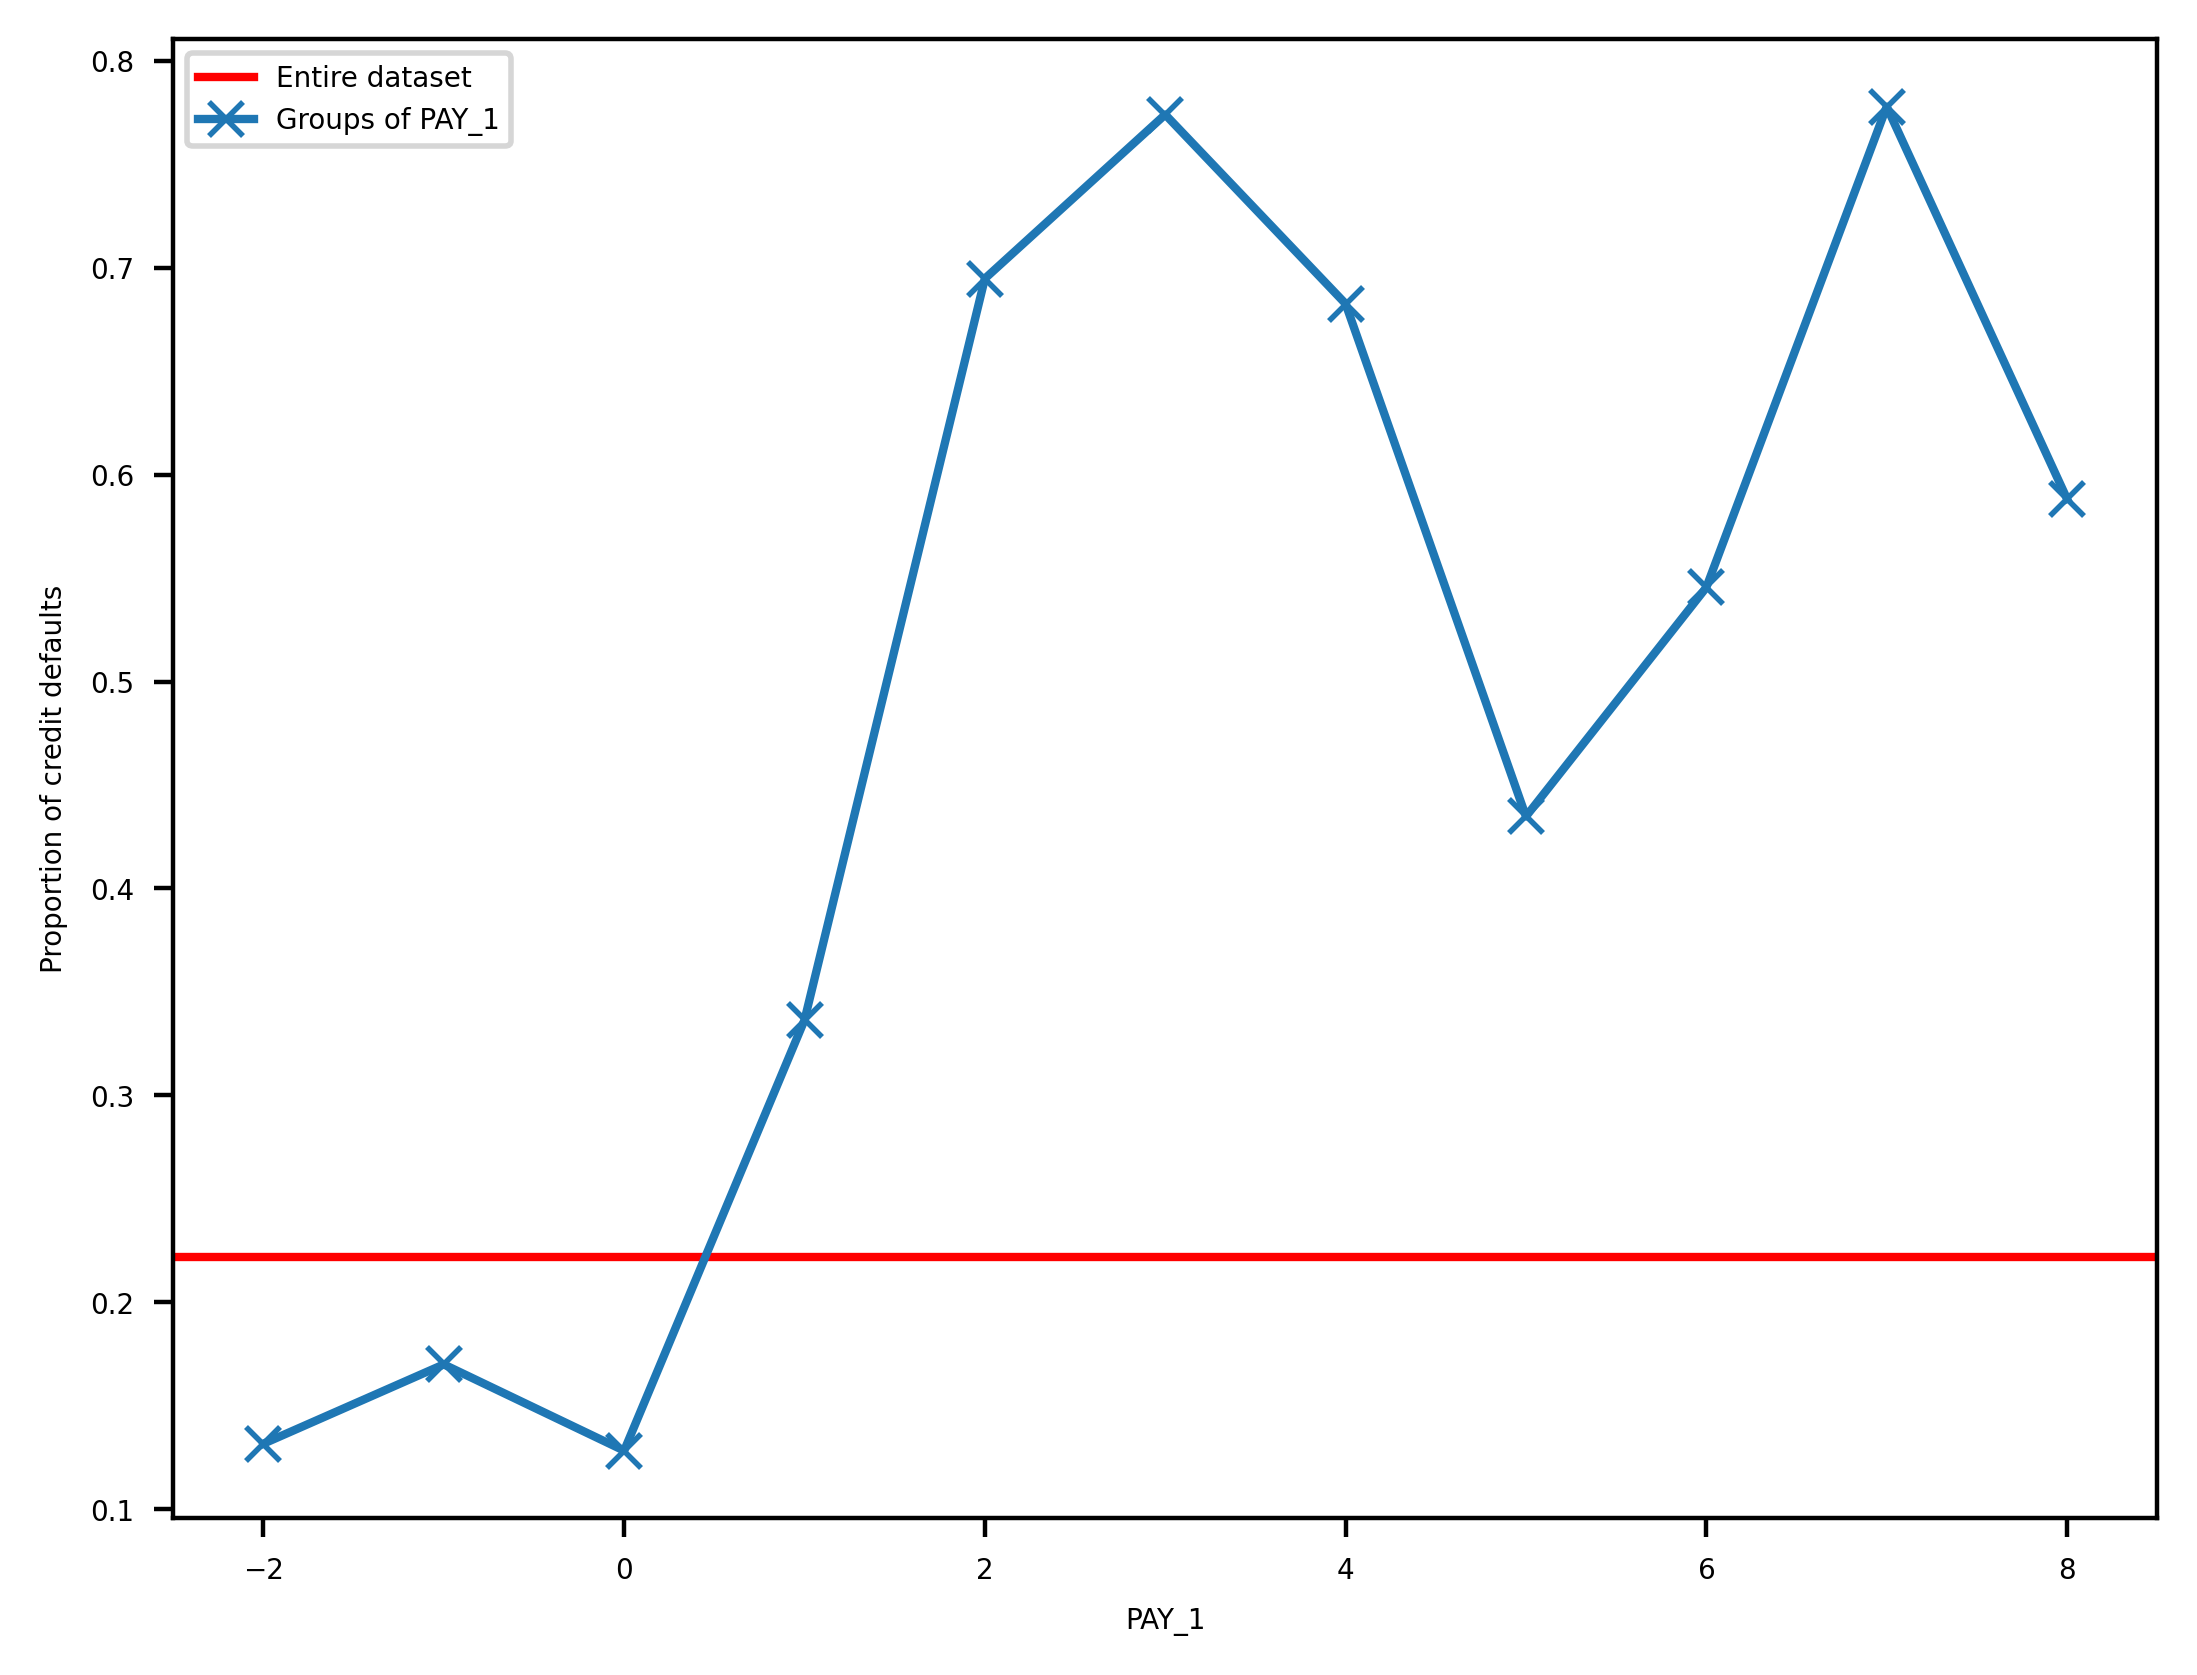

In [66]:
axes = plt.axes()
axes.axhline(overall_default_rate, color='red')
group_by_pay_mean_y.plot(marker='x', legend=False, ax=axes)
axes.set_ylabel('Proportion of credit defaults')
axes.legend(['Entire dataset', 'Groups of PAY_1']);

<p>Those who defaulted before are more likely to default again. The default rate of accounts in good standing is well below the overall default rate, which we know from before is about 22%. However, over 30% of the accounts that defaulted last month will default again next month.</p>

In [67]:
pos_mask = y == 1
neg_mask = y == 0
df['LIMIT_BAL'].max()

800000

In [68]:
bin_edges = list(range(0,850000,50000))
print(bin_edges)

[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000]


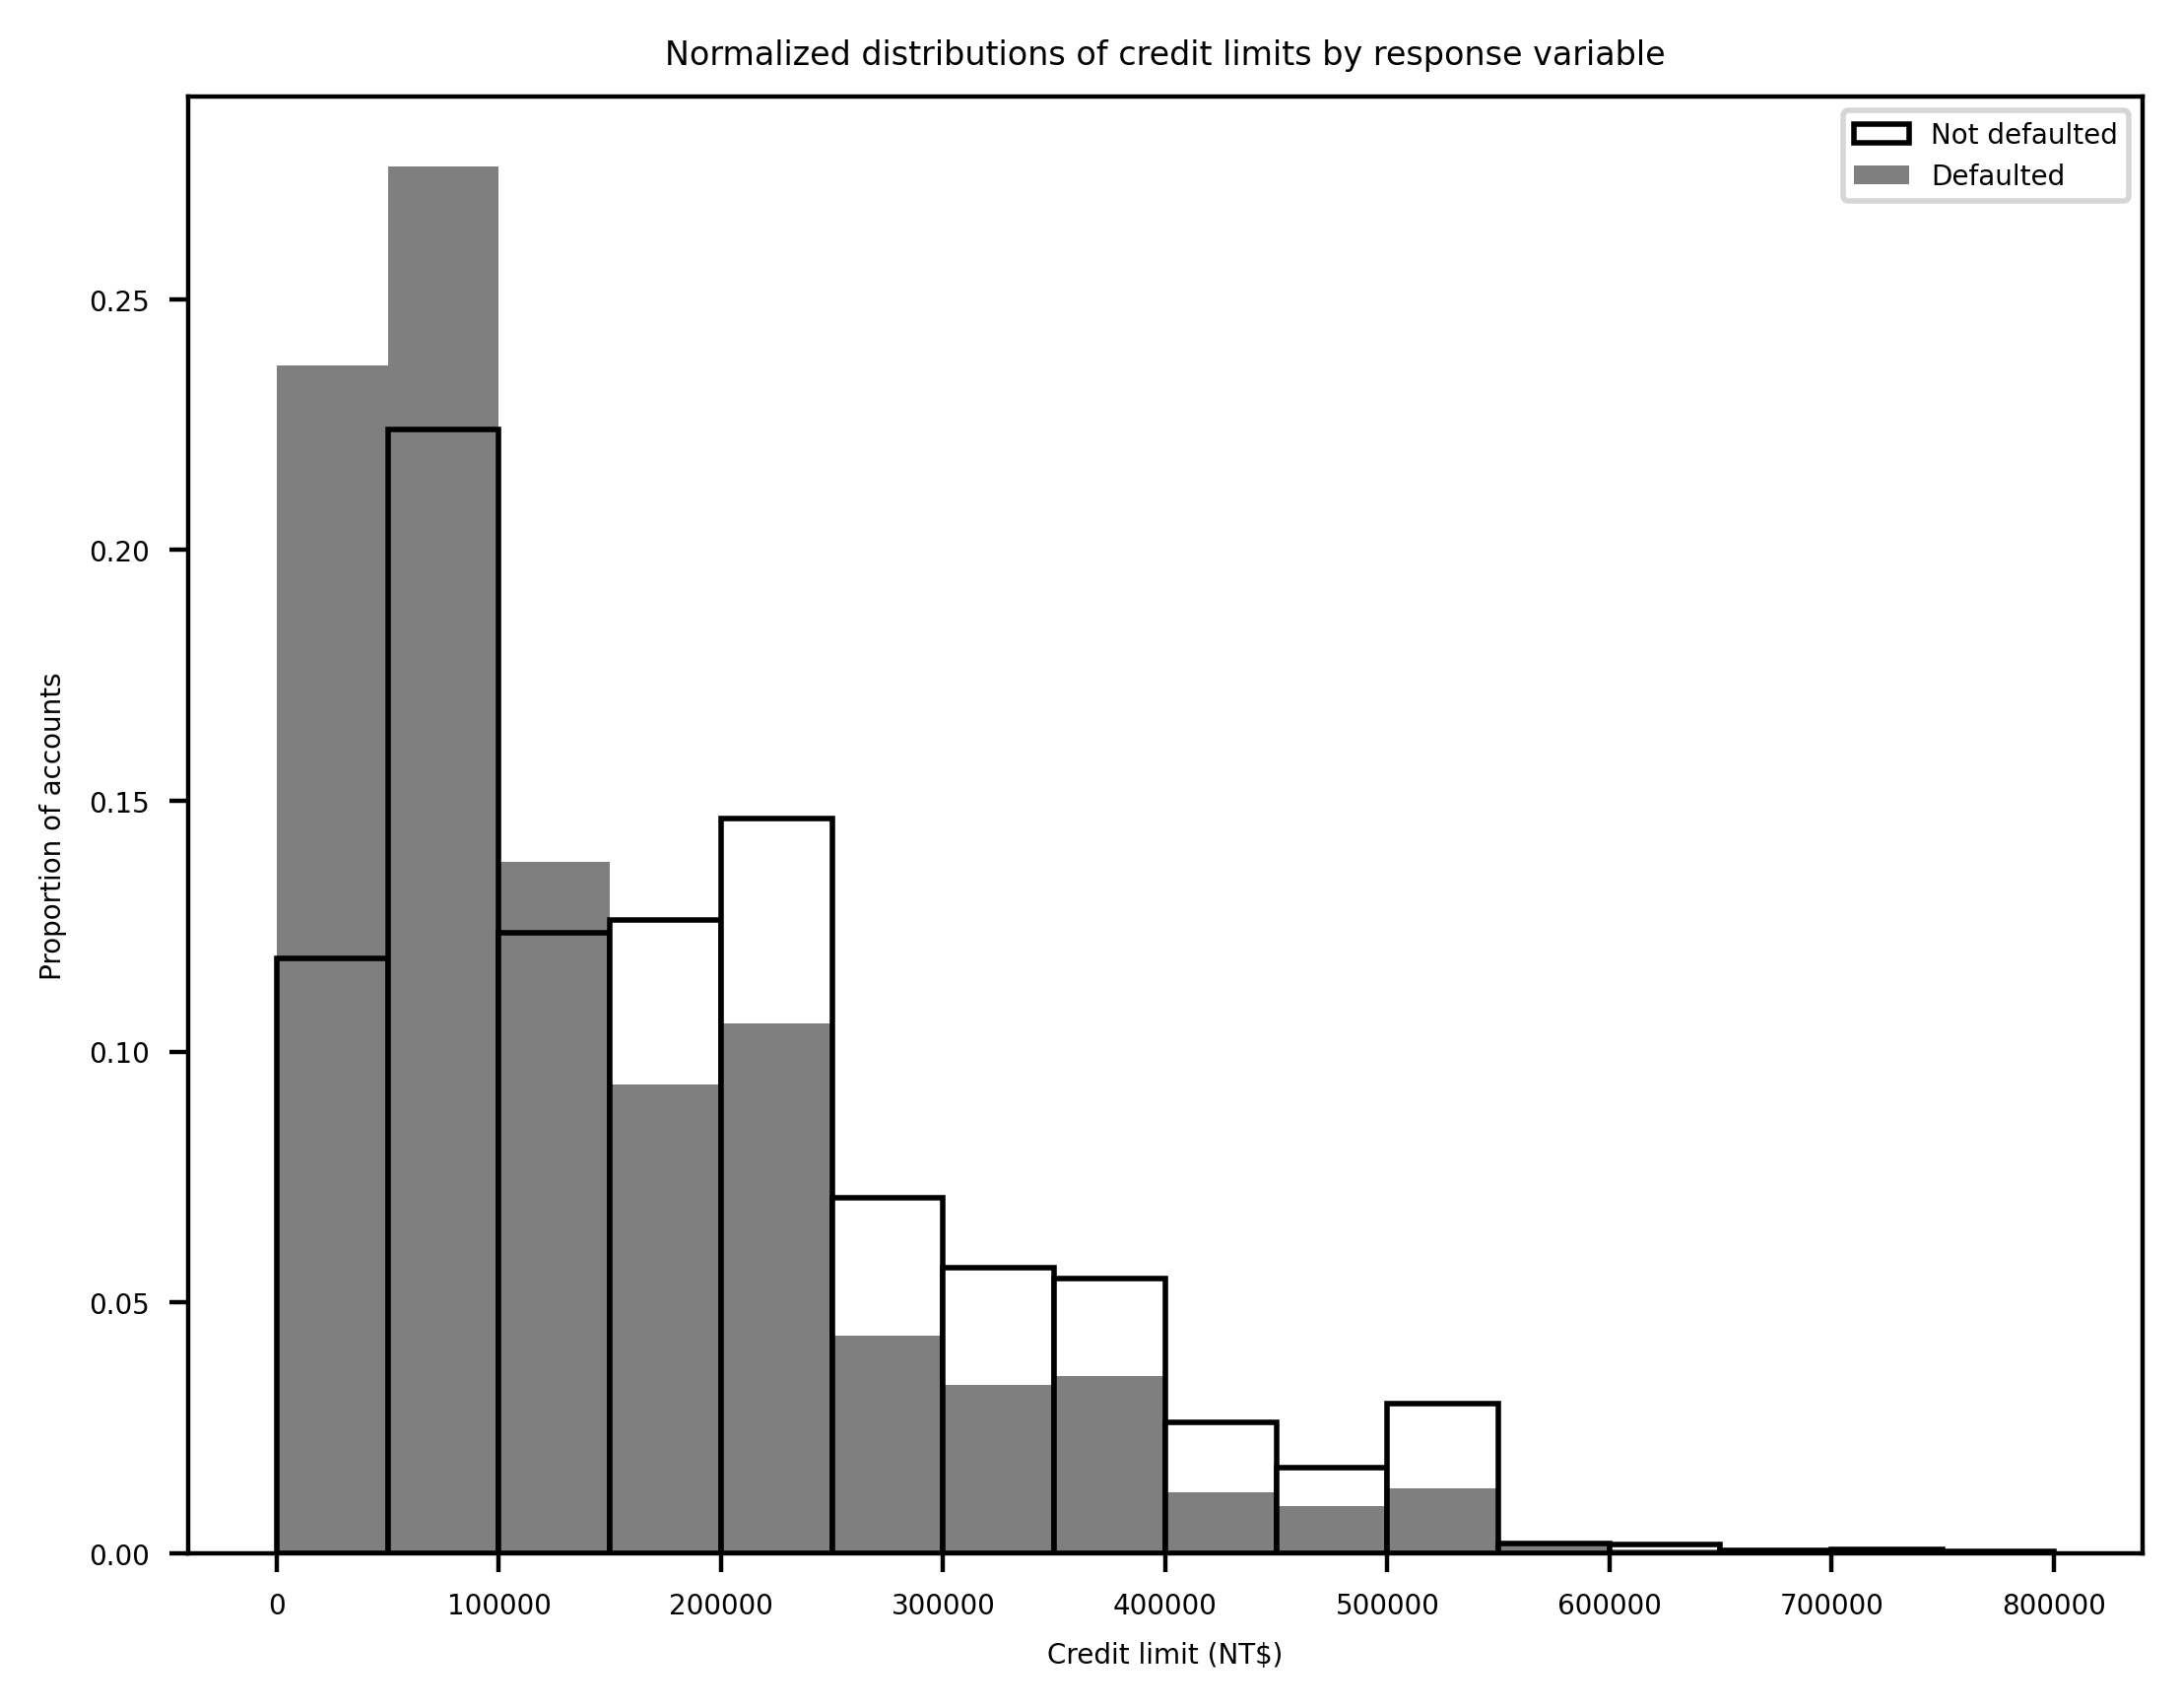

In [69]:
axes = plt.axes()
axes.hist(df.loc[neg_mask, 'LIMIT_BAL'], bins=bin_edges, density=True, edgecolor='black', color='white')
axes.hist(df.loc[pos_mask, 'LIMIT_BAL'], bins=bin_edges, density=True, alpha=0.5, edgecolor=None, color='black')
axes.set_xlabel('Credit limit (NT$)')
axes.set_ylabel('Proportion of accounts')
axes.set_title('Normalized distributions of credit limits by response variable');
def format_func(value, tick_number):
    return f'{value * 50000:.2f}'
axes.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
axes.legend(['Not defaulted', 'Defaulted']);

<p>The default accounts tend to have a higher proportion of lower credit limits. Accounts with credit limits less than NT$150,000 are relatively more likely to default, while the opposite is true for accounts with higher limits. We hypothesized that the client would give riskier accounts lower limits. This intuition is compatible with the higher proportions of defaulters with lower credit limits we observed here.</p>

<h2>Fitting a Logistic Regression Model and Directly Using the Coefficients</h2>

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['PAY_1', 'LIMIT_BAL']].values,
    df['default payment next month'].values,
    test_size=0.2, random_state=24)

In [71]:
print(X_train.shape)
print(X_test.shape)

(21331, 2)
(5333, 2)


In [72]:
lr_model = LogisticRegression(solver='liblinear')
lr_model

LogisticRegression(solver='liblinear')

In [73]:
lr_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [74]:
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)

In [75]:
# to create the array of features, with a column of ones added, using horizontal stacking

ones_and_features = np.hstack([np.ones((X_test.shape[0],1)), X_test])
ones_and_features

array([[ 1.0e+00,  2.0e+00,  1.6e+05],
       [ 1.0e+00,  1.0e+00,  5.0e+04],
       [ 1.0e+00, -1.0e+00,  2.0e+05],
       ...,
       [ 1.0e+00, -1.0e+00,  5.0e+04],
       [ 1.0e+00,  1.0e+00,  2.3e+05],
       [ 1.0e+00,  2.0e+00,  1.0e+05]])

In [76]:
# the intercept and coefficients

intercept_and_coefs = np.concatenate([lr_model.intercept_.reshape(1,1), lr_model.coef_], axis=1)
intercept_and_coefs

array([[-6.57647457e-11,  8.27451187e-11, -6.80876727e-06]])

In [77]:
# to repeatedly multiply the intercept and coefficients by all the rows of ones_and_features, and take the sum of each row (that is, find the linear combination)

X_lin_comb = np.dot(intercept_and_coefs, np.transpose(ones_and_features))

In [78]:
def sigmoid(X):
    Y = 1 / (1 + np.exp(-X))
    return Y

In [79]:
# X_lin_comb has the argument we need to pass to the sigmoid function we defined to calculate predicted probabilities
y_pred_proba_manual = sigmoid(X_lin_comb)

In [80]:
y_pred_manual = y_pred_proba_manual >= 0.5 # threshold of 0.5

# This array will have a different shape than y_pred but should contain the same values.

print(y_pred.shape)
print(y_pred_manual.shape)

(5333,)
(1, 5333)


In [81]:
# This should return a logical True if the arrays are equal.

np.array_equal(y_pred.reshape(1,-1), y_pred_manual)

True

In [82]:
print(y_test.shape)
print(y_pred_proba_manual.shape)

(5333,)
(1, 5333)


In [83]:
roc_auc_score(y_test, y_pred_proba_manual.reshape(y_pred_proba_manual.shape[1],))

0.627207450280691

In [84]:
roc_auc_score(y_test, y_pred_proba[:,1])

0.627207450280691

<h3>Assumptions of Logistic Regression</h3>
<p>Logistic regression is a linear model, which means it performs best when the features accurately represent a linear trend in the log odds. However, in our case, the main feature identified in univariate feature exploration, <code>PAY_1</code>, did not show a linear relationship in the log odds.</p>
<p>The clearest examples of correlated predictors in our case study data are the <code>BILL_AMT</code> features. It makes intuitive sense that bills might be similar from month to month for a given account. For instance, there may be an account that typically carries a balance of zero or an account with a large balance that takes a while to pay off. Are any of the <code>BILI_AMT</code> features perfectly correlated? <em>Please see the correlation plot of features and the response above.</em> It does not look like it. So, while these features may contribute little independent information, we won't remove them out of concern for multicollinearity.</p>
<p>We have been informed that each credit account is linked to a unique individual in our data, so we can assume that the observations are independent in this regard.</p>
<p>No outliers were observed in the histograms generated from our case study data during our feature exploration. Therefore, we do not have this concern.</p>
<p>For the case study data, we are fortunate to have a relatively large number of samples and relatively balanced features, so these are not concerns.</p>

<h2>Cross-Validation and Feature Engineering</h2>

In [85]:
features = features_response[:-1]
features

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [86]:
len(features)

17

In [87]:
X = df[features].values
X.shape

(26664, 17)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, df['default payment next month'].values,
                                                    test_size=0.2, random_state=24)
print(X_train.shape)
print(X_test.shape)

(21331, 17)
(5333, 17)


In [89]:
min_max_sc = MinMaxScaler()
lr = LogisticRegression(solver='saga', penalty='l1', max_iter=1000)
lr

LogisticRegression(max_iter=1000, penalty='l1', solver='saga')

In [90]:
scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc), ('model', lr)])
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [91]:
scale_lr_pipeline.get_params()['model__C']

1.0

In [92]:
scale_lr_pipeline.set_params(model__C = 2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [93]:
# to create a smaller range of C values to test with cross-validation

C_val_exponents = np.linspace(2,-3,6)
C_val_exponents

array([ 2.,  1.,  0., -1., -2., -3.])

In [94]:
C_vals = 10.0 ** C_val_exponents
C_vals

array([1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03])

In [95]:
n_folds = 4
k_folds = KFold(n_splits=n_folds, shuffle=False)

In [96]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #Count folds for each value of C
        fold_counter = 0
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fit the model on the training data
            pipeline.fit(X_cv_train, y_cv_train)

            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            #Increment the fold counter
            fold_counter += 1

        #Indicate progress
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [97]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: user 11.1 s, sys: 18.4 s, total: 29.5 s
Wall time: 5.69 s


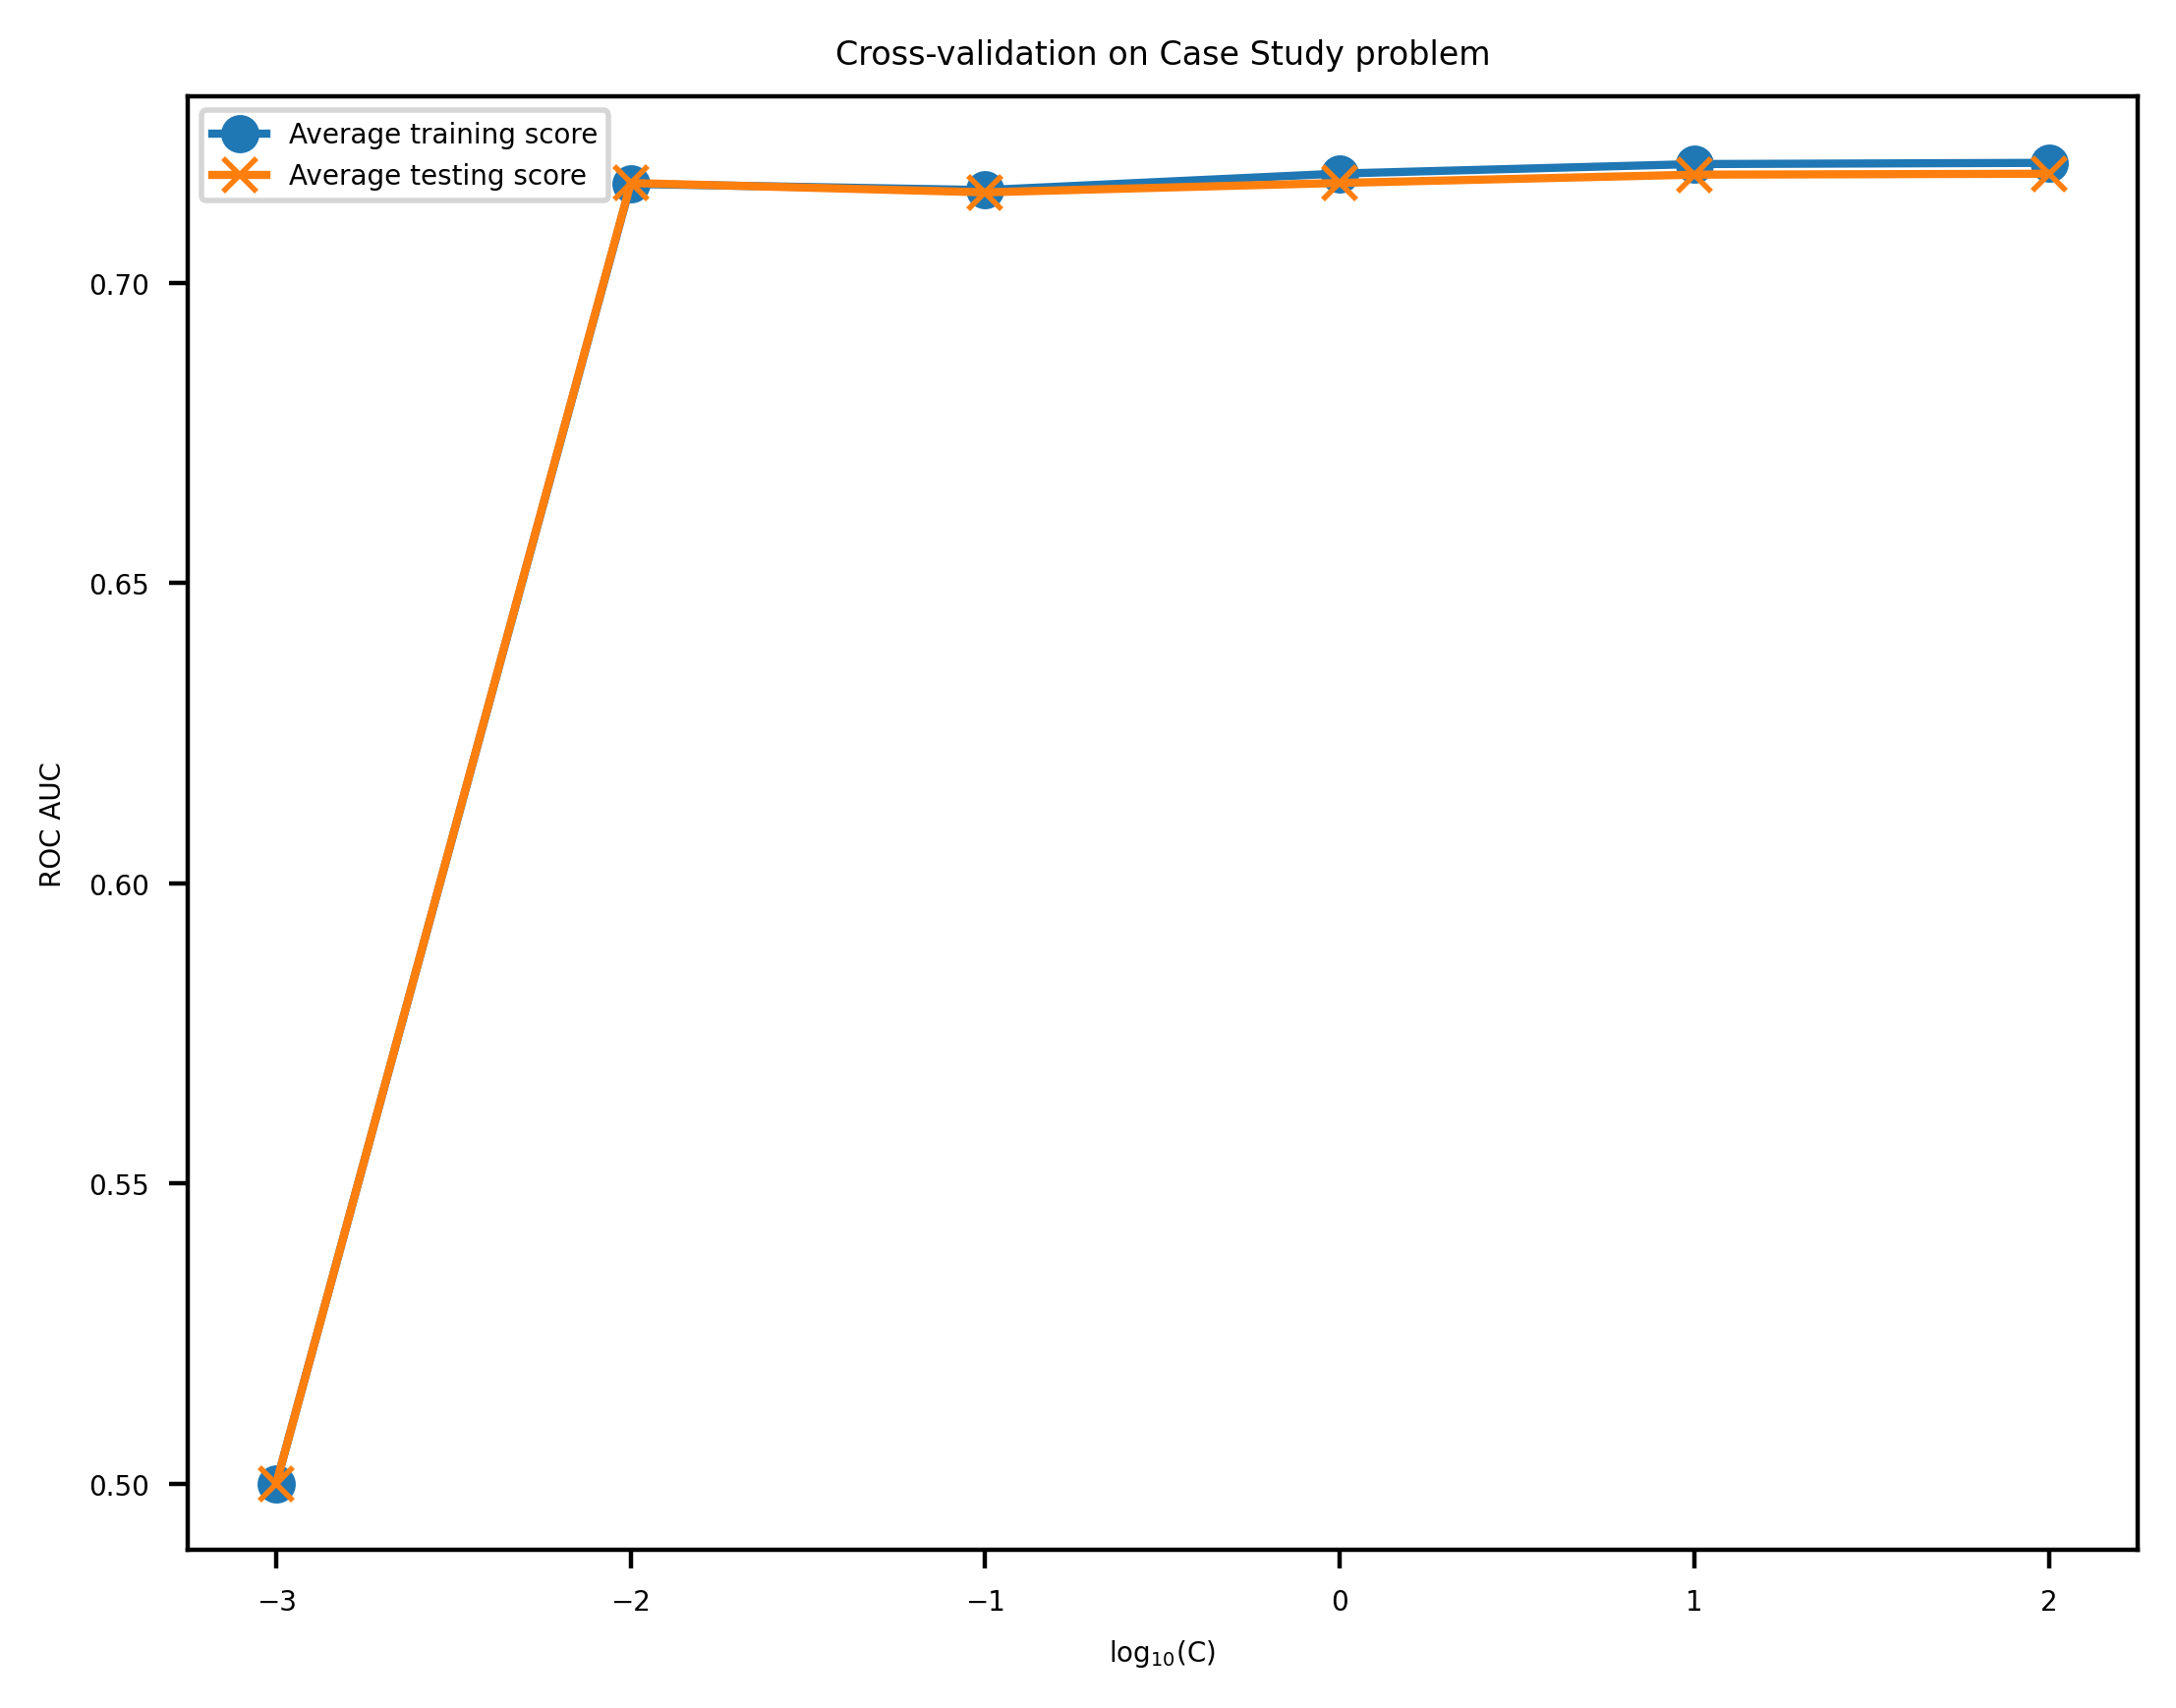

In [98]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x', label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross-validation on Case Study problem');

In [99]:
np.mean(cv_test_roc_auc, axis=0)

array([0.7181628 , 0.71800657, 0.71662886, 0.71506622, 0.71661792,
       0.5       ])

<p>Regularization does not impart much benefit here, as may be expected: for lower C values, which correspond to stronger regularization, model testing (as well as training) performance decreases. While we are able to increase model performance over our previous efforts by using all the features available, there is no overfitting going on. Instead, the training and test scores are about the same. Instead of overfitting, we may be underfitting. Let's try engineering some interaction features to see if they can improve performance.</p>

In [100]:
# to create interaction features
make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = make_interactions.fit_transform(X)
X_interact.shape

(26664, 153)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X_interact, df['default payment next month'].values,
                                                    test_size=0.2, random_state=24)
print(X_train.shape)
print(X_test.shape)

(21331, 153)
(5333, 153)


In [102]:
%%time
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals,
                                                                         scale_lr_pipeline,
                                                                         X_train, y_train)

/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 100.0


/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 10.0


/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/alinakurliantseva/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001
CPU times: user 3min 35s, sys: 29.3 s, total: 4min 5s
Wall time: 4min 40s


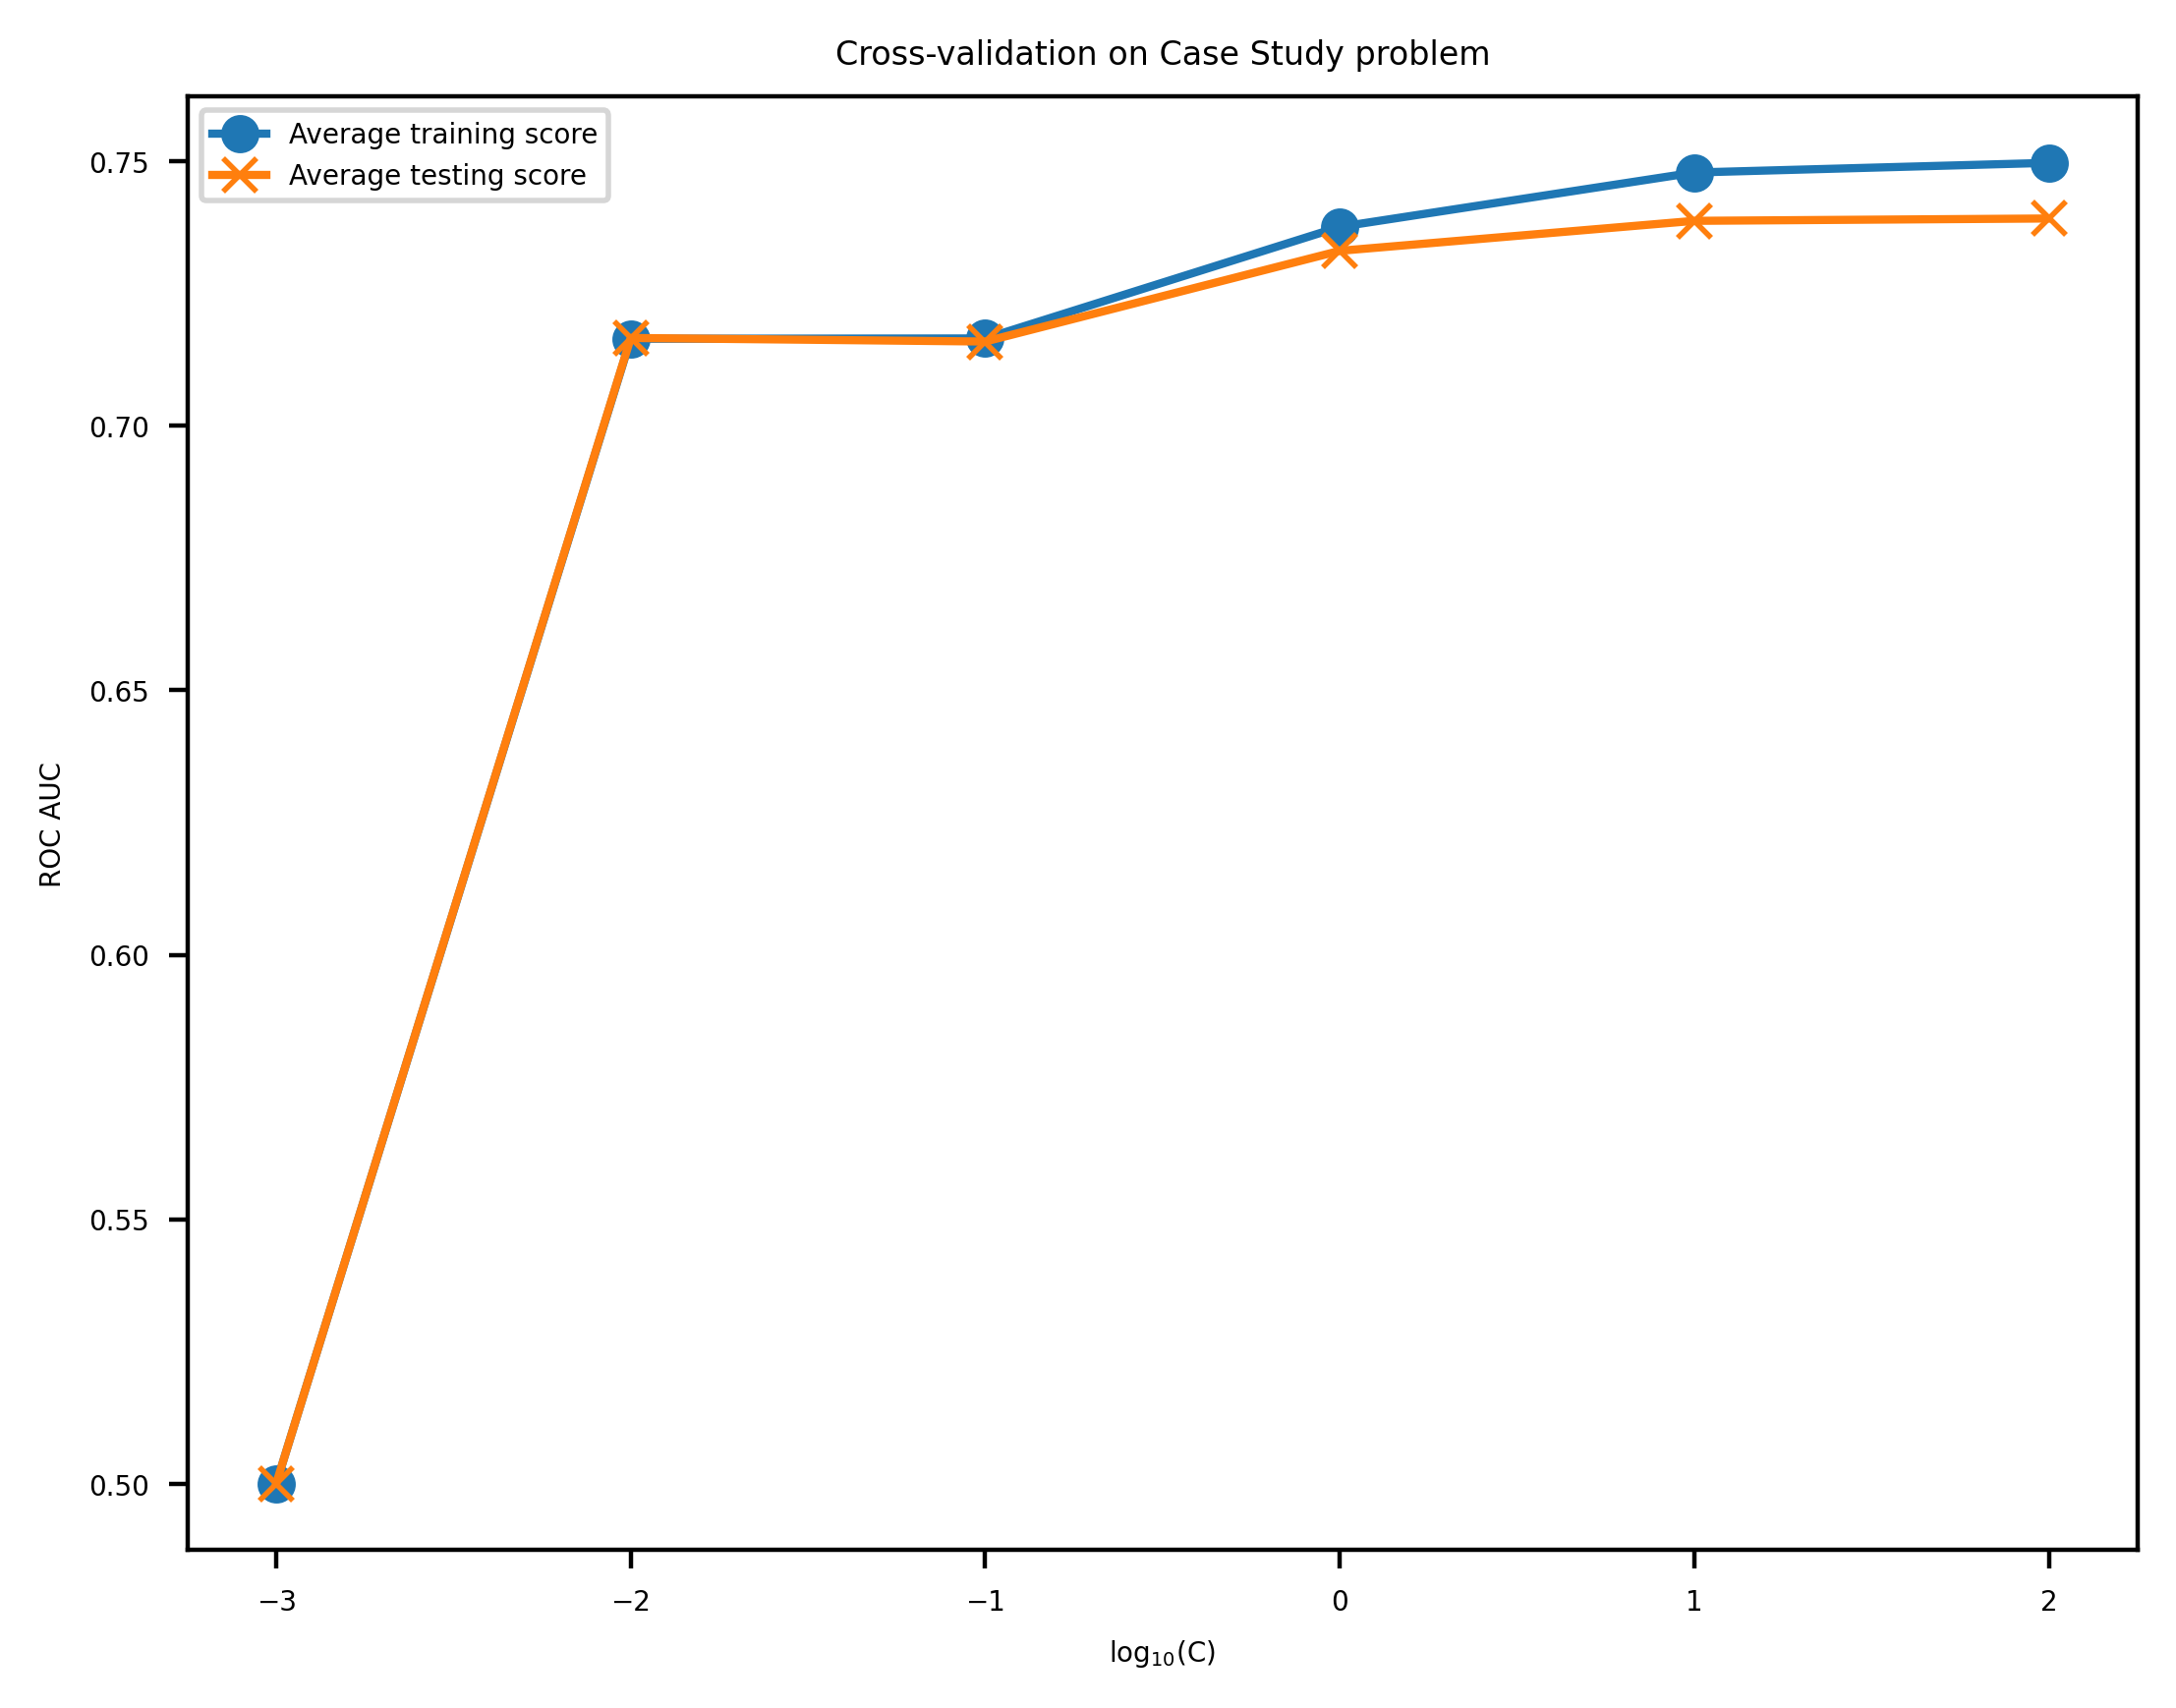

In [103]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x', label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross-validation on Case Study problem');

In [104]:
np.mean(cv_test_roc_auc, axis=0)

array([0.73920659, 0.73876221, 0.73309503, 0.71594083, 0.71661792,
       0.5       ])

<p>Engineering the interaction features increases the best model test score to about ROC AUC = 0.74 on average across the folds, from about 0.72 without including interactions. These scores happen at C = 100, that is, with negligible regularization. On the plot of training versus test scores for the model with interactions, you can see that the training score is a bit higher than the test score, so it could be said that some amount of overfitting is going on. However, we cannot increase the test score through regularization here, so this may be a manageable instance of overfitting.</p>

<h3>Side Notes</h3>

In [105]:
df['EDUCATION'].values.reshape(-1,1)

array([[2],
       [2],
       [2],
       ...,
       [2],
       [3],
       [2]])

In [106]:
df['default payment next month'].values

array([1, 1, 0, ..., 1, 1, 1])

In [107]:
X_train, X_test, y_train, y_test = train_test_split(df['EDUCATION'].values.reshape(-1,1),
                                                    df['default payment next month'].values,
                                                    test_size=0.2, random_state=24)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21331, 1)
(5333, 1)
(21331,)
(5333,)


In [108]:
print(np.mean(y_train))
print(np.mean(y_test))

# The positive class fractions in the training and test data are about 22%.

0.223102526838873
0.21657603600225014


In [109]:
example_lr = LogisticRegression()
example_lr.fit(X_train, y_train)

LogisticRegression()

In [110]:
y_pred = example_lr.predict(X_test)

# We have saved the model-predicted labels of the test set in a variable called y_pred.
# We have the actual labels stored in the y_test variable.

In [111]:
# Accuracy (the simplest of all binary classification metrics) is the proportion of correctly classified samples.

example_lr.score(X_test, y_test) # an accuracy of 78%

# Our dataset shows that about 22% of the samples are positive. So, the negative class is the majority class,
# with the remaining 78% of the samples. Therefore, a null model for this dataset,
# which always predicts the majority negative class, will be right 78% of the time.
# Now, when we compare our trained model here to such a null model,
# it becomes clear that an accuracy of 78% is not very useful.
# We can get the same accuracy with a model that doesn't pay attention to the features.

0.7834239639977498

In [112]:
metrics.confusion_matrix(y_test, y_pred) # The confusion matrix contains all the information we need to calculate the TPR, FNR, TNR, and FPR.

array([[4178,    0],
       [1155,    0]])

In [113]:
y_pred_proba = example_lr.predict_proba(X_test)
y_pred_proba

# The first column represents the probability of the negative class,
# while the second column represents the probability of the positive class.

array([[0.77460214, 0.22539786],
       [0.77460214, 0.22539786],
       [0.79040961, 0.20959039],
       ...,
       [0.79040961, 0.20959039],
       [0.79040961, 0.20959039],
       [0.79040961, 0.20959039]])

In [114]:
pos_proba = y_pred_proba[:,1]
pos_proba

array([0.22539786, 0.22539786, 0.20959039, ..., 0.20959039, 0.20959039,
       0.20959039])

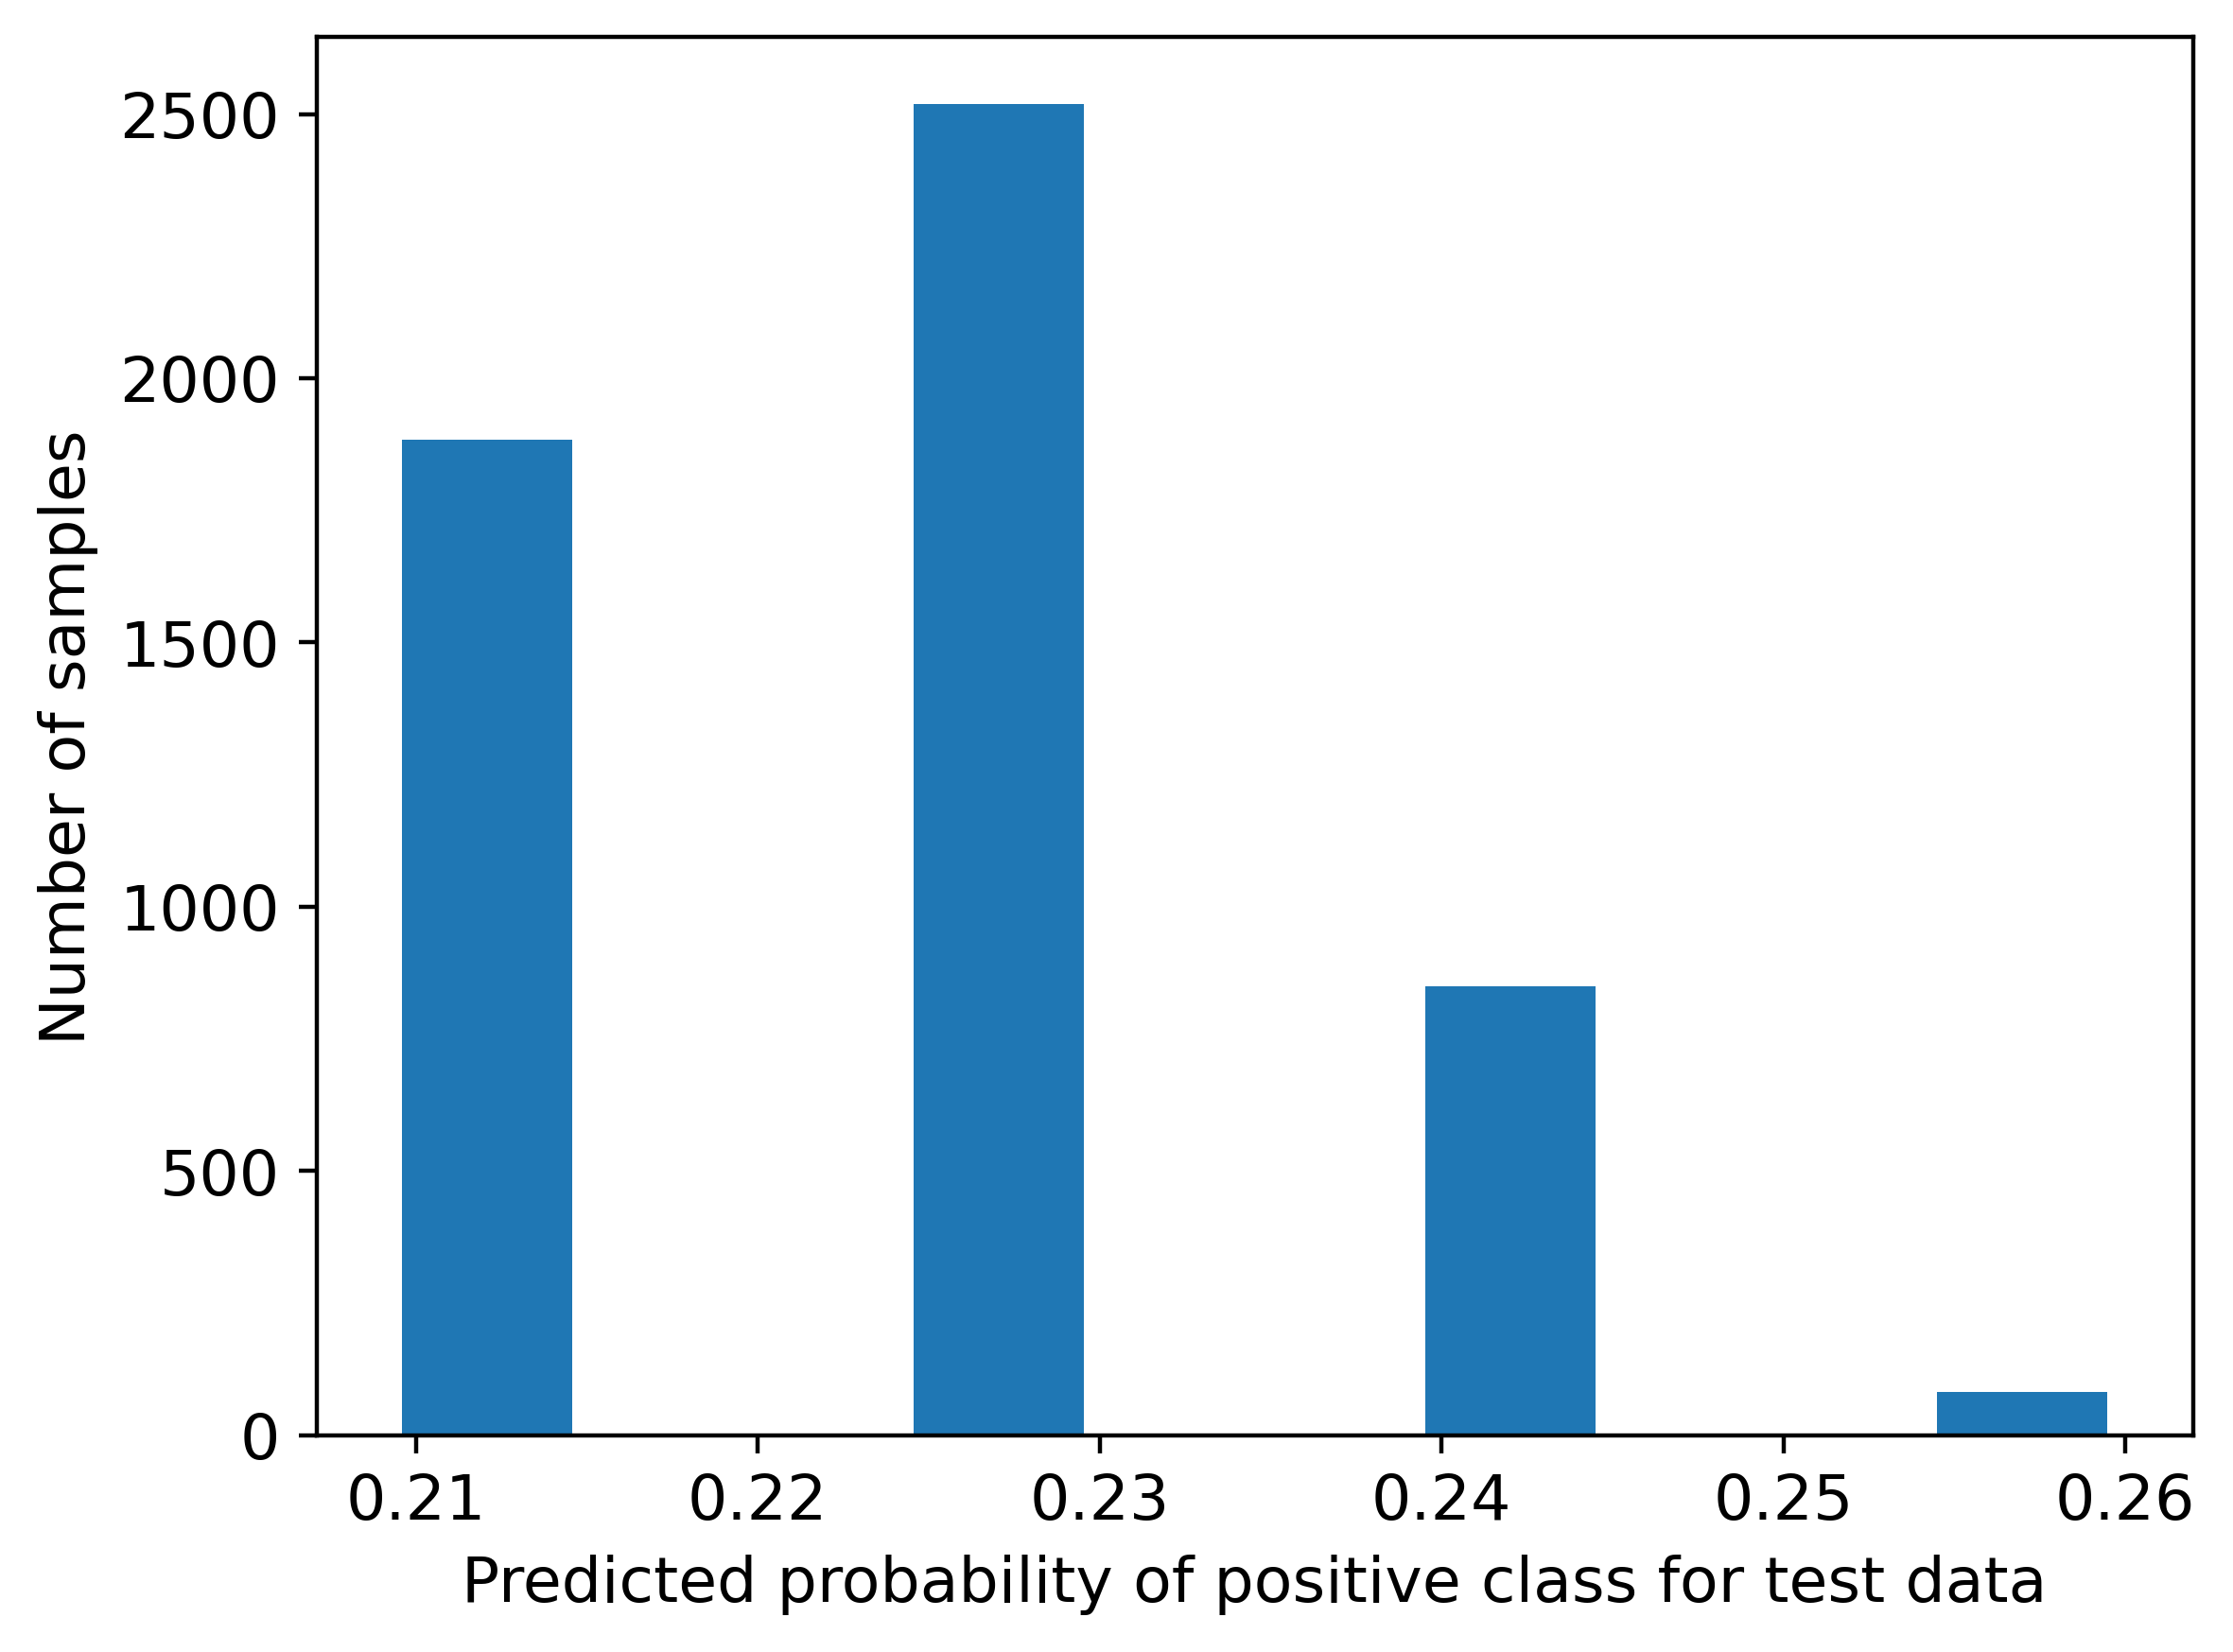

In [115]:
mpl.rcParams['font.size'] = 12
plt.hist(pos_proba)
plt.xlabel('Predicted probability of positive class for test data')
plt.ylabel('Number of samples');

<p>There are only four bins that actually have samples in them, and they are spaced relatively far apart. This is because there are only four unique values for the <code>EDUCATION</code> feature, the only feature in our example model.</p>
<p>All the predicted probabilities are below 0.5. As a result, every sample was predicted to be negative using the 0.5 threshold.</p>

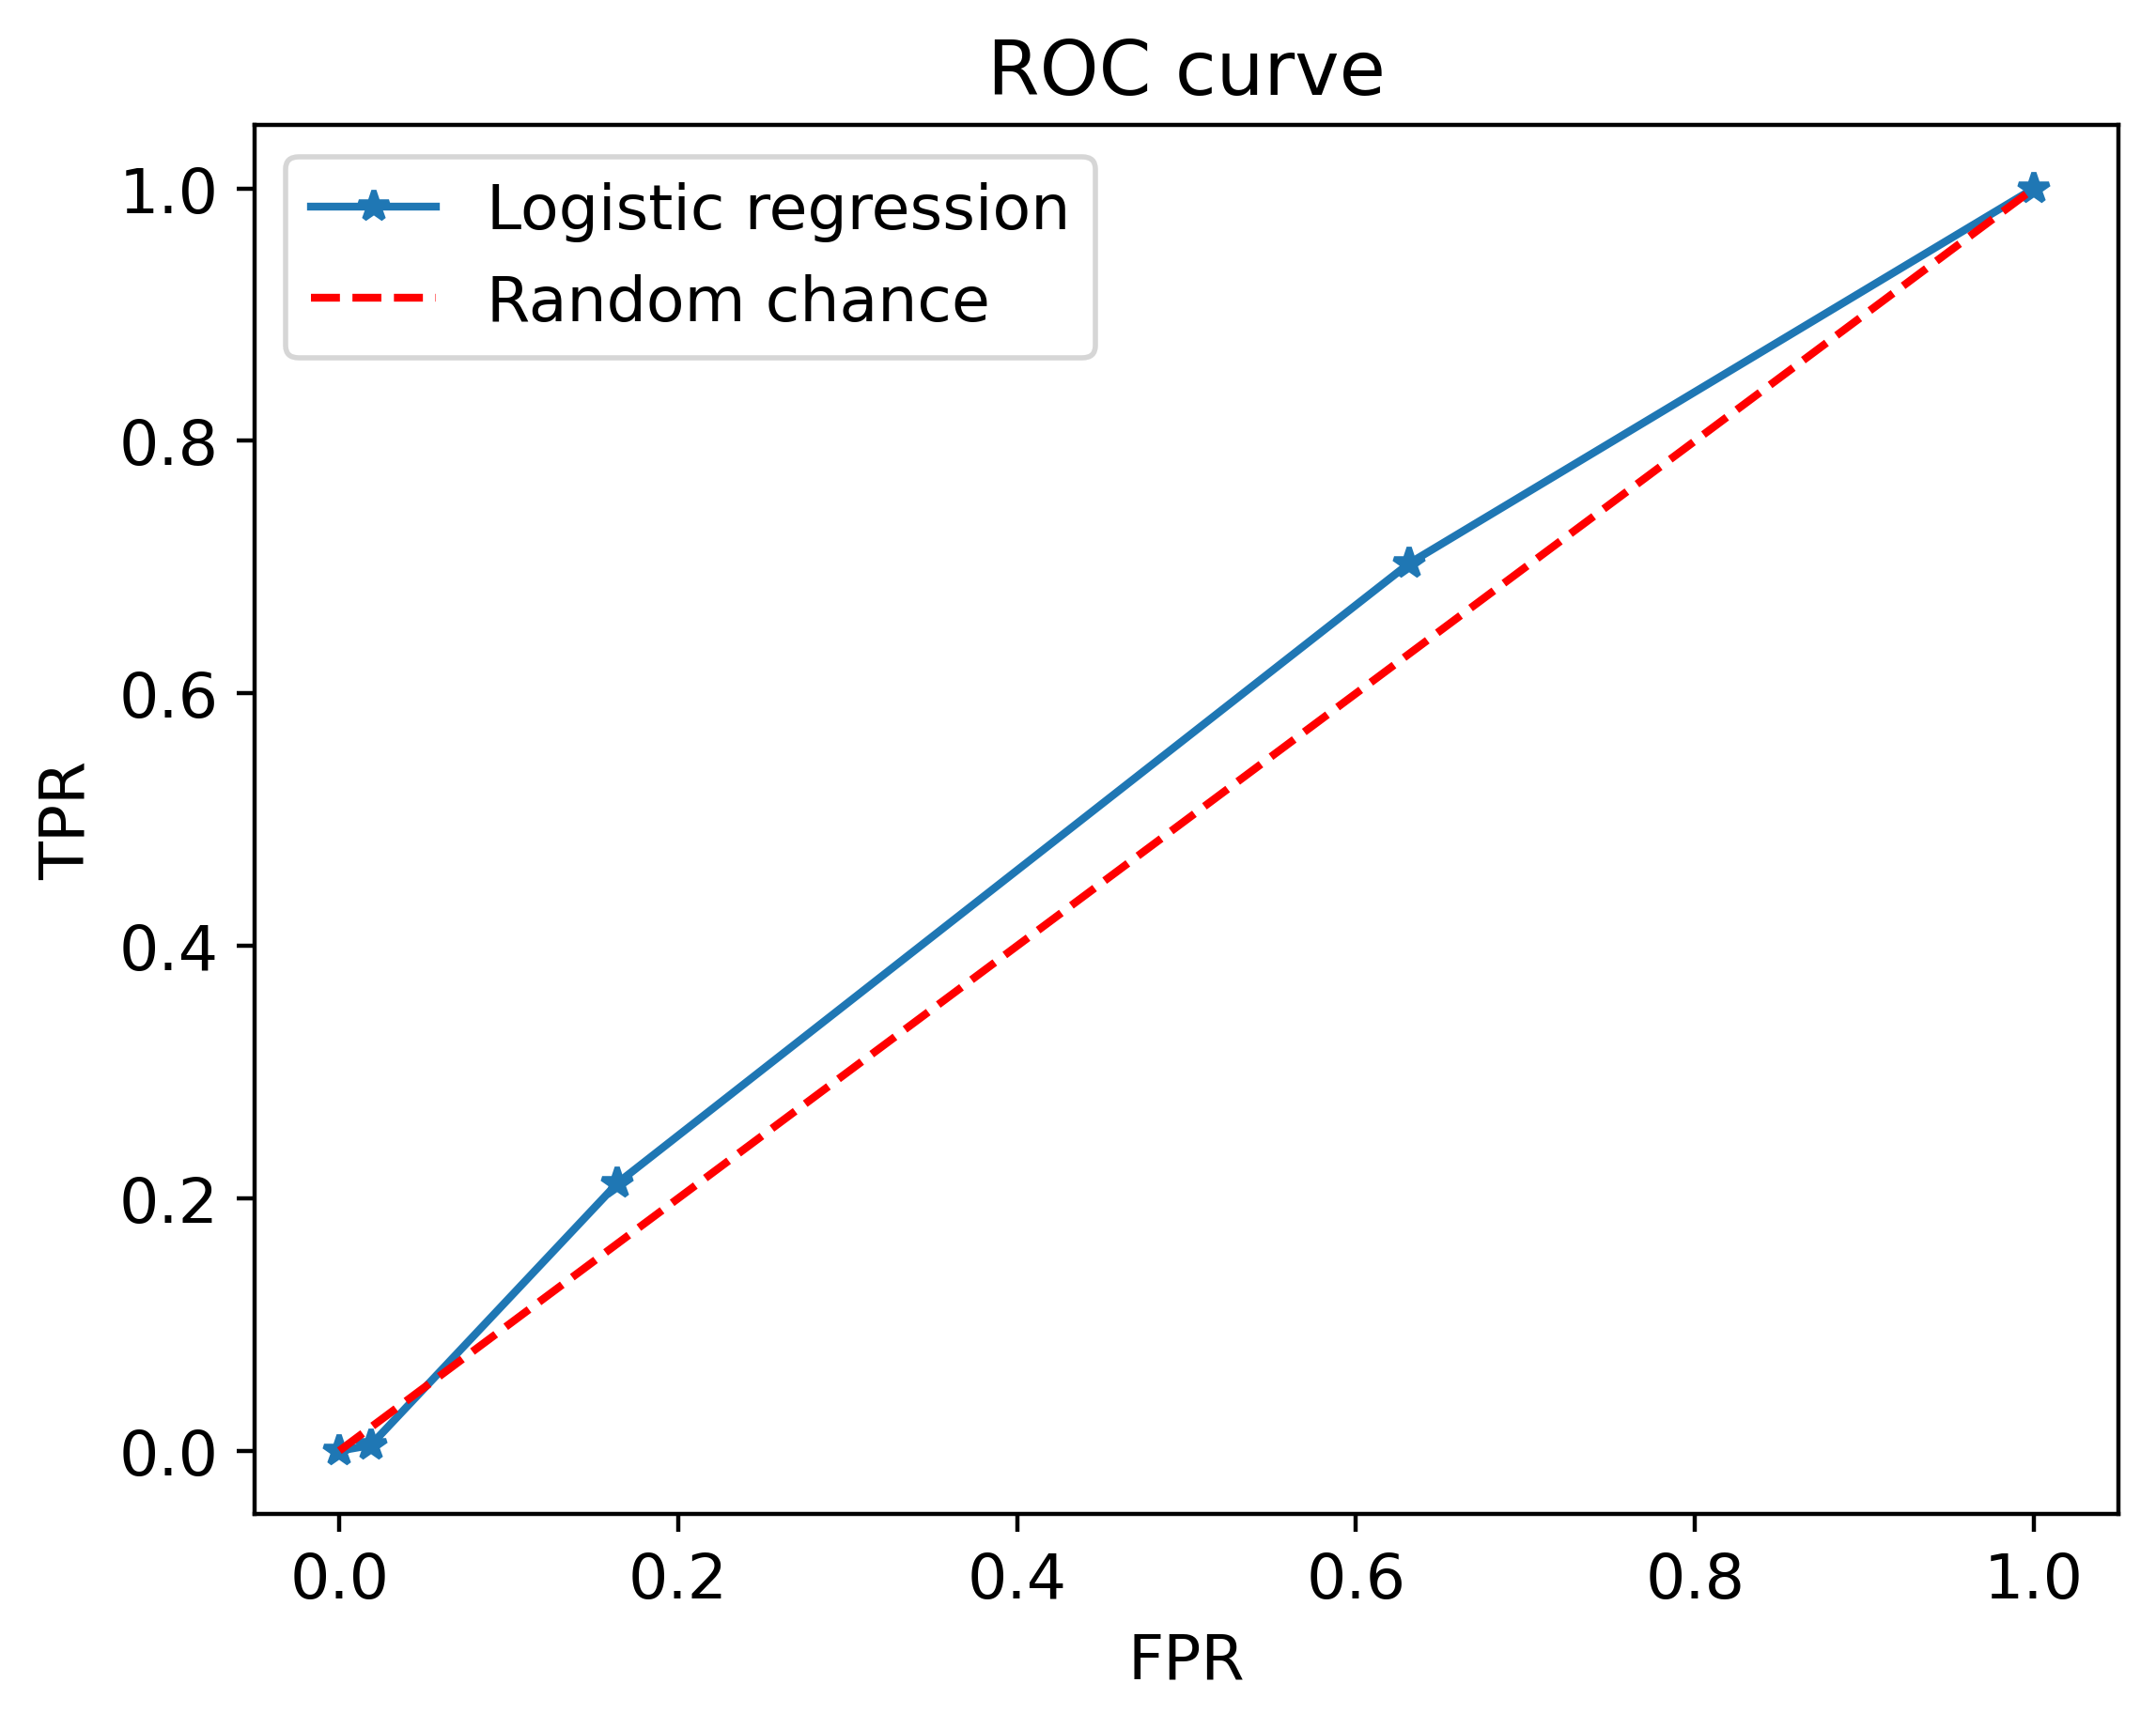

In [116]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, '*-') # x = FPRs, y = TPRs, * - data points
plt.plot([0, 1], [0, 1], 'r--') # from (0, 0) to (1, 1)
plt.legend(['Logistic regression', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve');

In [117]:
metrics.roc_auc_score(y_test, pos_proba)

# The ROC AUC for the logistic regression is close to 0.5, indicating it is not an effective classifier.

0.5434650477972642

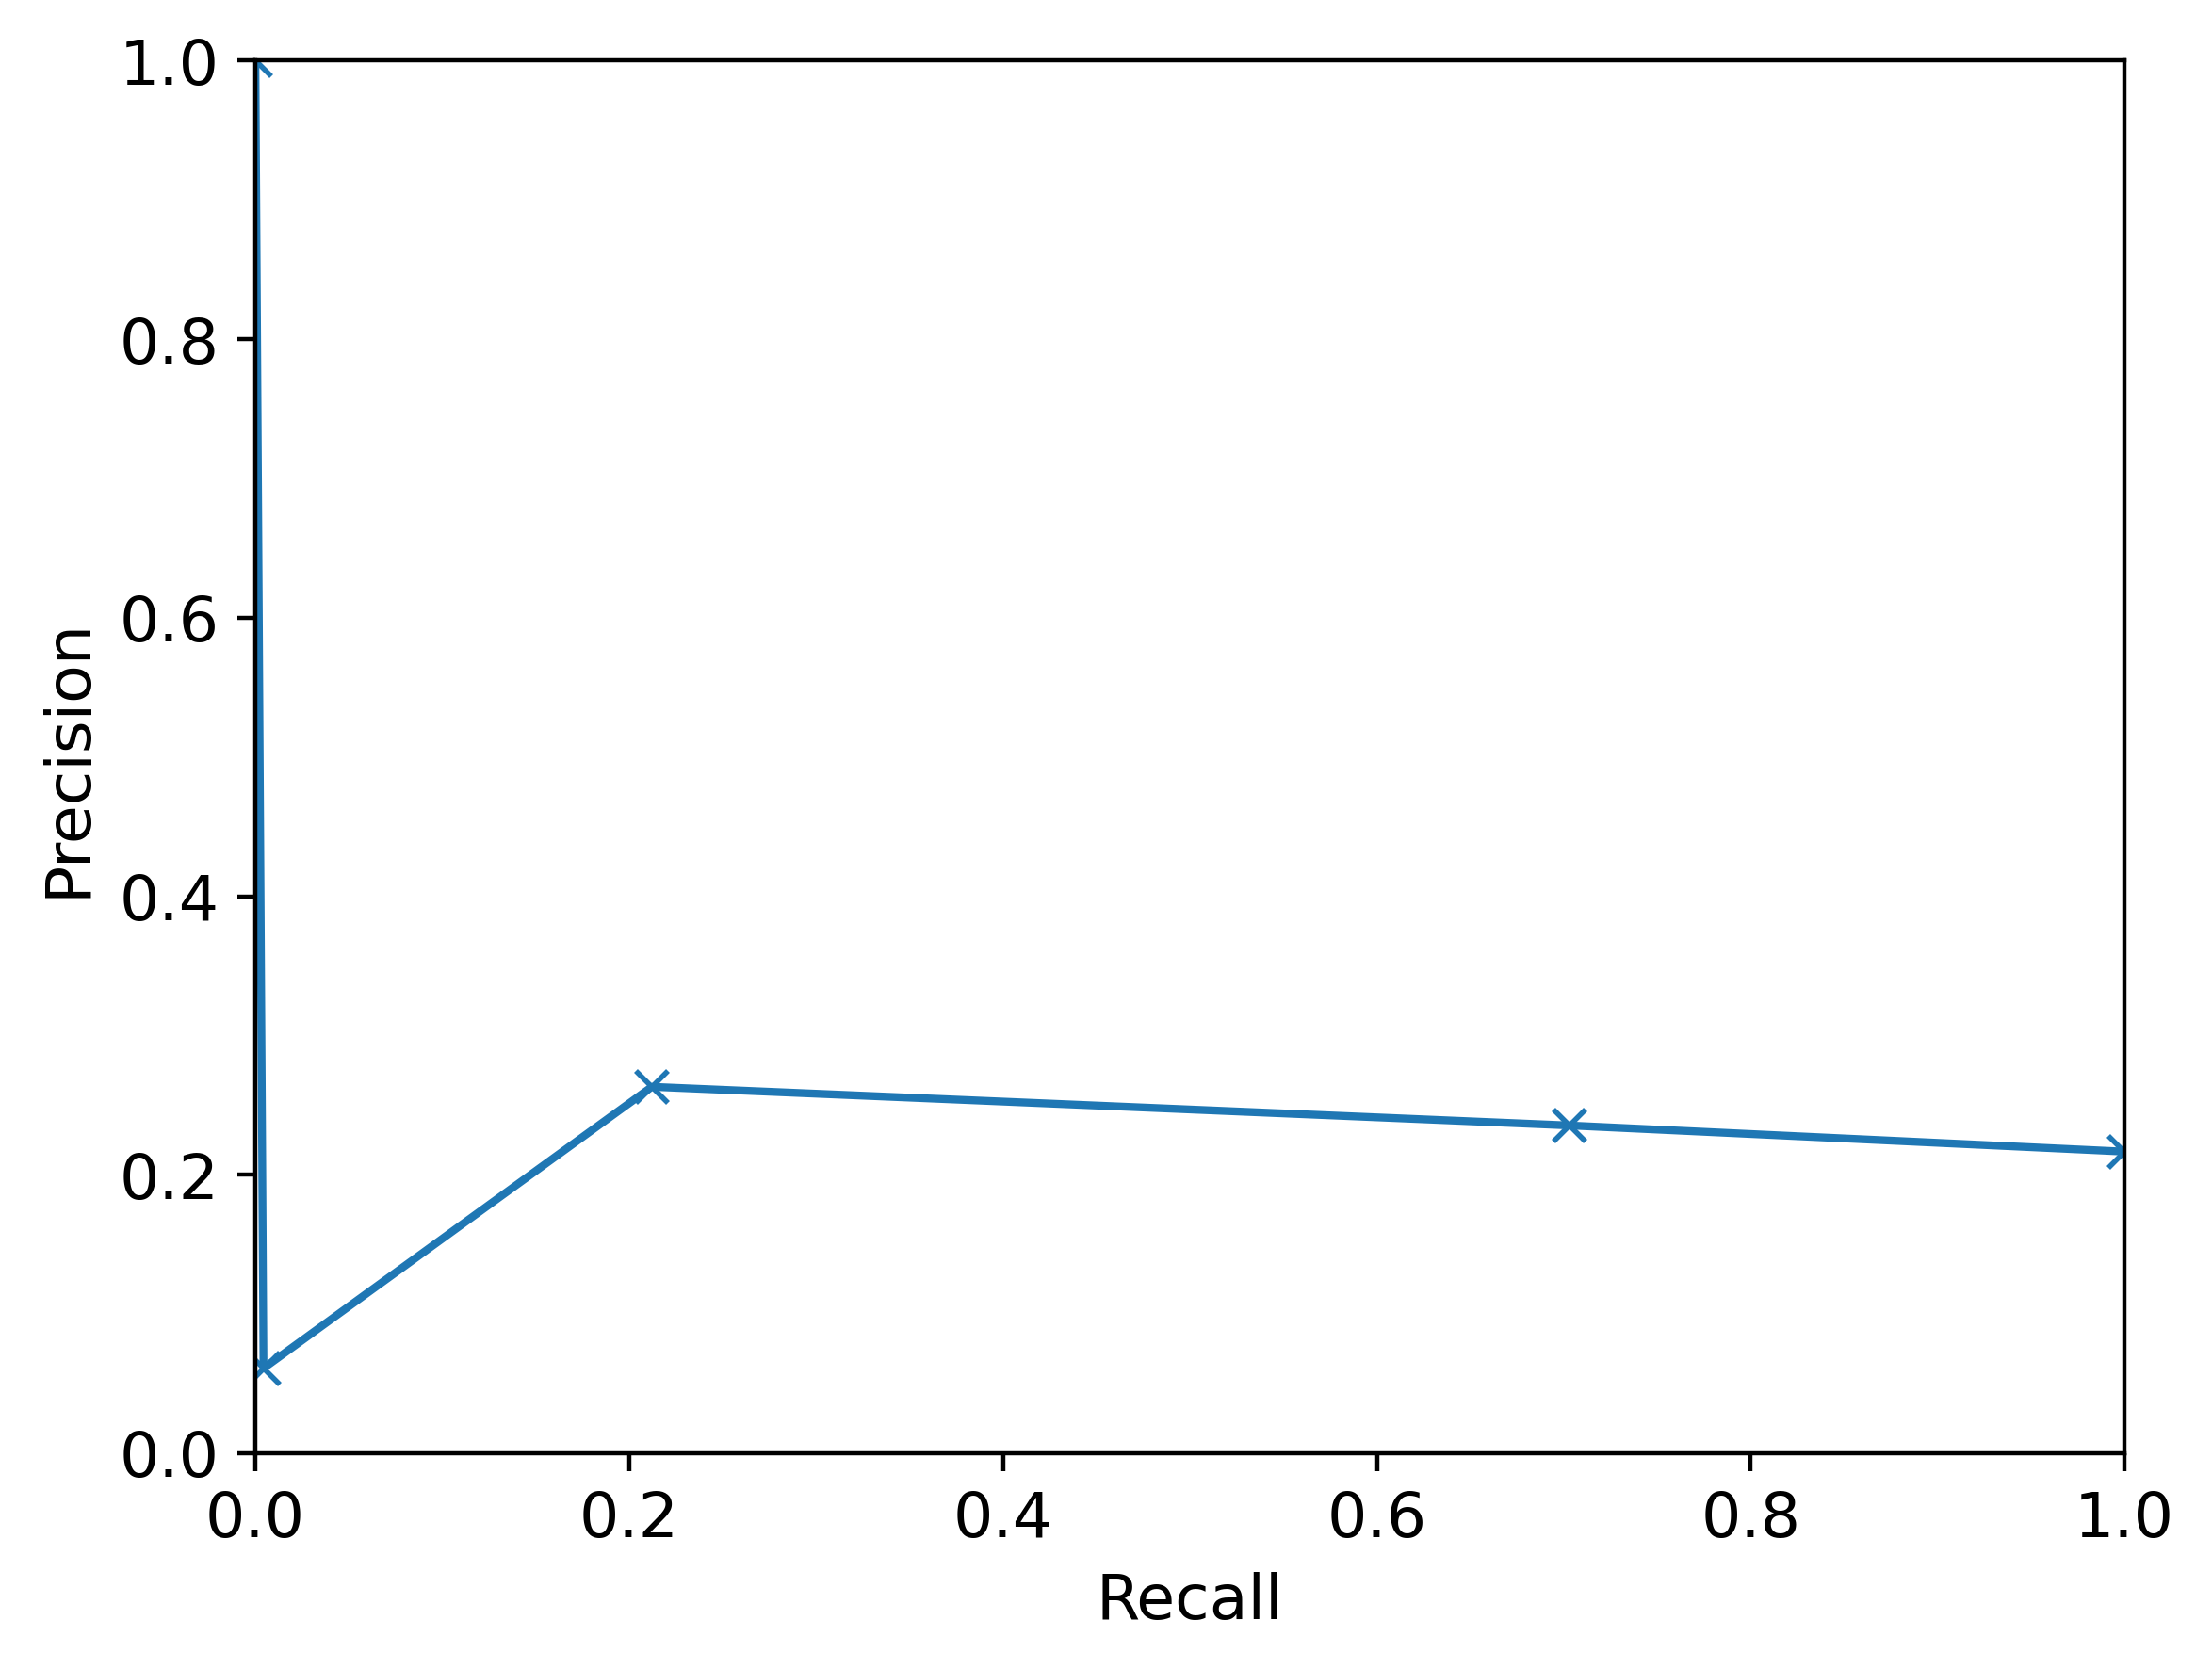

In [118]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, pos_proba)
plt.plot(recall, precision, '-x')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1]);

In [119]:
metrics.auc(recall, precision)

0.22544274282968607

<h2>Decision Trees and Random Forests</h2>